In [414]:
# %pip install ta

In [415]:
# conda install -c conda-forge mlxtend

# Set up

In [416]:
import pandas as pd
import numpy as np
import warnings
import ta
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
    TimeSeriesSplit,
    RandomizedSearchCV,
)
from sklearn.ensemble import (
    GradientBoostingClassifier,
    RandomForestClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from datetime import timedelta, datetime
import yfinance as yf
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
from scipy.stats import chi2_contingency
from itertools import combinations
from sklearn.metrics import roc_auc_score
import seaborn as sns


# Set pandas options
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)



# Feature Engineering

## Price and Index

In [417]:
# Stock Name
stock_name = 'ERW.BK'
# stock_name = 'TISCO.BK'
# stock_name = 'SPRC.BK'

# ตั้งค่าวันที่
cur_date = datetime.now().strftime('%Y-%m-%d')
date_60_days_ago = (datetime.now() - timedelta(days=59)).strftime('%Y-%m-%d')

# ดึงข้อมูล ERW.BK
df = yf.download(stock_name, start=date_60_days_ago, end=cur_date, interval='15m')

# ดึงข้อมูลสินค้าโภคภัณฑ์และดัชนีตลาดหลักทรัพย์
# ตัวอย่าง: ทองคำ (Gold), น้ำมัน (Crude Oil), SET Index, Dow Jones, S&P 500
# โปรดแทนที่ 'SYMBOL' ด้วยตัวย่อของแต่ละสินค้าหรือดัชนี
df_gold = yf.download('GC=F', start=date_60_days_ago, end=cur_date, interval='15m')
df_oil = yf.download('CL=F', start=date_60_days_ago, end=cur_date, interval='15m')
df_set = yf.download('^SET.BK', start=date_60_days_ago, end=cur_date, interval='15m')
df_dji = yf.download('^DJI', start=date_60_days_ago, end=cur_date, interval='15m')
df_sp500 = yf.download('^GSPC', start=date_60_days_ago, end=cur_date, interval='15m')

# เพิ่มคำนำหน้าในแต่ละ feature ของ DataFrame
df = df.add_prefix(f'{stock_name}_')
df_gold = df_gold.add_prefix('Gold_')
df_oil = df_oil.add_prefix('Oil_')
df_set = df_set.add_prefix('SET_')
df_dji = df_dji.add_prefix('DJI_')
df_sp500 = df_sp500.add_prefix('SP500_')

# ดึงข้อมูลดัชนี SET50
df_set50 = yf.download('^SET50.BK', start=date_60_days_ago, end=cur_date, interval='15m')

# ดึงข้อมูลดัชนี SET100
df_set100 = yf.download('^SET100.BK', start=date_60_days_ago, end=cur_date, interval='15m')

# เพิ่มคำนำหน้าในแต่ละ feature ของ DataFrame ของดัชนี SET50 และ SET100
df_set50 = df_set50.add_prefix('SET50_')
df_set100 = df_set100.add_prefix('SET100_')

# รวม DataFrame ทั้งหมดเข้าด้วยกัน โดยใช้วันที่เป็น index
df_combined = pd.concat([df, df_gold, df_oil, df_set, df_dji, df_sp500, df_set50, df_set100], axis=1)

# เลือกเฉพาะแถวที่อยู่ใน df_erw
df_selected = df_combined[df_combined[f'{stock_name}_Close'].notnull()]
df = df_selected

# แสดงผล DataFrame ที่เลือก
display(df.head(5))


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,ERW.BK_Open,ERW.BK_High,ERW.BK_Low,ERW.BK_Close,ERW.BK_Adj Close,ERW.BK_Volume,Gold_Open,Gold_High,Gold_Low,Gold_Close,Gold_Adj Close,Gold_Volume,Oil_Open,Oil_High,Oil_Low,Oil_Close,Oil_Adj Close,Oil_Volume,SET_Open,SET_High,SET_Low,SET_Close,SET_Adj Close,SET_Volume,DJI_Open,DJI_High,DJI_Low,DJI_Close,DJI_Adj Close,DJI_Volume,SP500_Open,SP500_High,SP500_Low,SP500_Close,SP500_Adj Close,SP500_Volume,SET50_Open,SET50_High,SET50_Low,SET50_Close,SET50_Adj Close,SET50_Volume,SET100_Open,SET100_High,SET100_Low,SET100_Close,SET100_Adj Close,SET100_Volume
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-11-15 10:00:00,5.20,5.20,5.15,5.20,5.20,92000.0,1960.800049,1962.800049,1960.599976,1961.699951,1961.699951,4171.0,77.260002,77.379997,77.089996,77.190002,77.190002,7570.0,1402.560059,1403.869995,1401.060059,1401.719971,1401.719971,0.0,34917.820312,34947.789062,34898.750000,34941.500000,34941.500000,11213192.0,4506.220215,4511.299805,4505.459961,4510.839844,4510.839844,99025412.0,872.179993,872.960022,871.080017,871.450012,871.450012,0.0,1925.959961,1927.660034,1923.640015,1924.469971,1924.469971,0.0
2023-11-15 10:15:00,5.20,5.20,5.15,5.15,5.15,1169300.0,1961.699951,1964.099976,1960.699951,1963.800049,1963.800049,3554.0,77.199997,77.370003,77.010002,77.260002,77.260002,9022.0,1401.869995,1406.569946,1401.869995,1404.750000,1404.750000,0.0,34941.738281,34986.671875,34941.738281,34958.781250,34958.781250,11477319.0,4510.859863,4519.560059,4510.839844,4514.660156,4514.660156,98341235.0,871.590027,874.789978,871.460022,873.390015,873.390015,0.0,1924.780029,1932.109985,1924.439941,1928.510010,1928.510010,0.0
2023-11-15 10:30:00,5.20,5.25,5.15,5.20,5.20,3720701.0,1963.900024,1965.800049,1963.199951,1964.800049,1964.800049,4279.0,77.260002,77.800003,77.190002,77.639999,77.639999,16621.0,1405.280029,1408.329956,1404.430054,1407.640015,1407.640015,0.0,34958.261719,34976.410156,34951.898438,34957.750000,34957.750000,9505943.0,4514.649902,4518.490234,4512.520020,4517.299805,4517.299805,88423584.0,873.710022,875.909973,873.289978,875.229980,875.229980,0.0,1929.790039,1934.489990,1927.939941,1933.270020,1933.270020,0.0
2023-11-15 10:45:00,5.25,5.25,5.20,5.20,5.20,97220.0,1964.800049,1968.300049,1964.800049,1966.800049,1966.800049,4161.0,77.639999,77.660004,77.089996,77.180000,77.180000,8023.0,1407.729980,1409.520020,1407.130005,1407.609985,1407.609985,0.0,34957.429688,34983.488281,34956.851562,34973.910156,34973.910156,10281987.0,4517.290039,4521.169922,4517.290039,4518.549805,4518.549805,85697429.0,875.330017,876.510010,874.409973,874.830017,874.830017,0.0,1933.459961,1935.910034,1932.130005,1932.400024,1932.400024,0.0
2023-11-15 11:00:00,5.20,5.25,5.20,5.20,5.20,158400.0,1966.900024,1967.400024,1965.699951,1966.300049,1966.300049,2450.0,77.169998,77.190002,76.940002,77.059998,77.059998,9654.0,1407.729980,1409.660034,1406.579956,1408.739990,1408.739990,0.0,34974.300781,34996.859375,34942.308594,34944.308594,34944.308594,11438296.0,4518.500000,4520.879883,4513.950195,4514.109863,4514.109863,81044019.0,875.049988,875.869995,873.750000,874.979980,874.979980,0.0,1933.130005,1935.390015,1930.910034,1933.650024,1933.650024,0.0


In [418]:
len(df.columns)

48

## Generate log file

In [419]:
# Log Data Daily
df.to_csv(stock_name + cur_date +'_'+ date_60_days_ago+'.csv')

# last_dt_prefer = datetime.date(2024, 1, 6) # Adjust this
# last_dt_prefer_str = last_dt_prefer.strftime('%Y-%m-%d')
# date_60_days_ago_prefer = (last_dt_prefer - timedelta(days=59)).strftime('%Y-%m-%d')
# df = pd.read_csv(stock_name + last_dt_prefer_str +'_'+ date_60_days_ago_prefer+'.csv')

## Indicator

In [420]:
close_col = f'{stock_name}_Close'
low_col = f'{stock_name}_Low'
high_col = f'{stock_name}_High'
volume_col = f'{stock_name}_Volume'

def calculate_indicators(df, windows, stock_name):
    # Define necessary columns
    close_col = f'{stock_name}_Close'
    low_col = f'{stock_name}_Low'
    high_col = f'{stock_name}_High'
    volume_col = f'{stock_name}_Volume'

    # Technical indicators
    for window in windows:
        # Simple and Exponential Moving Averages
        df[f'SMA_{window}'] = ta.trend.sma_indicator(df[close_col], window=window)
        df[f'EMA_{window}'] = ta.trend.ema_indicator(df[close_col], window=window)

        # Stochastic Oscillator
        stoch = ta.momentum.StochasticOscillator(df[high_col], df[low_col], df[close_col], window=window, smooth_window=3)
        df[f'Stoch_%K_{window}'] = stoch.stoch()
        df[f'Stoch_%D_{window}'] = stoch.stoch_signal()
        # Stochastic Buy and Sell Signals
        df[f'Stoch_Buy_{window}'] = ((df[f'Stoch_%K_{window}'] > df[f'Stoch_%D_{window}']) & (df[f'Stoch_%K_{window}'].shift() < df[f'Stoch_%D_{window}'].shift())).astype(int)
        df[f'Stoch_Sell_{window}'] = ((df[f'Stoch_%K_{window}'] < df[f'Stoch_%D_{window}']) & (df[f'Stoch_%K_{window}'].shift() > df[f'Stoch_%D_{window}'].shift())).astype(int)

        # Relative Strength Index
        df[f'RSI_{window}'] = ta.momentum.rsi(df[close_col], window=window)
        # RSI Buy and Sell Signals
        df[f'RSI_Buy_{window}'] = (df[f'RSI_{window}'] < 30).astype(int)  # RSI below 30 indicates buy signal
        df[f'RSI_Sell_{window}'] = (df[f'RSI_{window}'] > 70).astype(int)  # RSI above 70 indicates sell signal


        # Williams %R
        df[f'WPR_{window}'] = ta.momentum.williams_r(df[high_col], df[low_col], df[close_col], lbp=window)

        # Average True Range
        df[f'ATR_{window}'] = ta.volatility.average_true_range(df[high_col], df[low_col], df[close_col], window=window)

        # Commodity Channel Index
        df[f'CCI_{window}'] = ta.trend.cci(df[high_col], df[low_col], df[close_col], window=window)

        # Bollinger Bands
        bollinger = ta.volatility.BollingerBands(df[close_col], window=window, window_dev=2)
        df[f'Bollinger_mavg_{window}'] = bollinger.bollinger_mavg()
        df[f'Bollinger_hband_{window}'] = bollinger.bollinger_hband()
        df[f'Bollinger_lband_{window}'] = bollinger.bollinger_lband()

       # VWAP (Volume-Weighted Moving Average)
        typical_price = (df[high_col] + df[low_col] + df[close_col]) / 3
        vwap_cumulative = (typical_price * df[volume_col]).cumsum()
        df[f'VWAP_{window}'] = vwap_cumulative / df[volume_col].cumsum()

        # สร้างสัญญาณซื้อและขายสำหรับ VWAP
        df[f'VWAP_Buy_{window}'] = (df[close_col] > df[f'VWAP_{window}']).astype(int)
        df[f'VWAP_Sell_{window}'] = (df[close_col] < df[f'VWAP_{window}']).astype(int)

        # CMF (Chaikin Money Flow)
        df[f'CMF_{window}'] = ta.volume.chaikin_money_flow(df[high_col], df[low_col], df[close_col], df[volume_col], window=window)
        # สร้างสัญญาณซื้อและขายสำหรับ CMF
        df[f'CMF_Buy_{window}'] = ((df[f'CMF_{window}'] > 0) & (df[f'CMF_{window}'].shift() < 0)).astype(int)
        df[f'CMF_Sell_{window}'] = ((df[f'CMF_{window}'] < 0) & (df[f'CMF_{window}'].shift() > 0)).astype(int)

        # Parabolic SAR
        df[f'Parabolic_SAR_{window}'] = ta.trend.PSARIndicator(df[high_col], df[low_col], df[close_col], step=0.02, max_step=0.2).psar()

        # Fibonacci Retracements
        highest = df[high_col].rolling(window=window).max()
        lowest = df[low_col].rolling(window=window).min()
        df[f'Fibonacci_Retracement_23.6_{window}'] = highest - (highest - lowest) * 0.236
        df[f'Fibonacci_Retracement_38.2_{window}'] = highest - (highest - lowest) * 0.382


   # ROC (Price Rate of Change)
    df['ROC'] = ta.momentum.roc(df[close_col], window=12)  # ตัวอย่างใช้ window=12 สำหรับ ROC
    # สร้างสัญญาณซื้อและขายสำหรับ ROC
    df['ROC_Buy'] = ((df['ROC'] > 0) & (df['ROC'].shift() < 0)).astype(int)
    df['ROC_Sell'] = ((df['ROC'] < 0) & (df['ROC'].shift() > 0)).astype(int)

    # MACD indicator
    macd = ta.trend.MACD(df[close_col])
    df['MACD'] = macd.macd()
    df['MACD_signal'] = macd.macd_signal()
    df['MACD_diff'] = macd.macd_diff()
    # MACD Buy and Sell Signals
    df['MACD_Buy'] = ((df['MACD'] > df['MACD_signal']) & (df['MACD'].shift() < df['MACD_signal'].shift())).astype(int)
    df['MACD_Sell'] = ((df['MACD'] < df['MACD_signal']) & (df['MACD'].shift() > df['MACD_signal'].shift())).astype(int)
    
    # Additional indicators
    df['Momentum'] = df[close_col].diff(4)
    df['ROC'] = df[close_col].pct_change(periods=4)
    df['OBV'] = ta.volume.on_balance_volume(df[close_col], df[volume_col])
    df['Close_pct_change'] = df[close_col].pct_change()

    # Time-based Features
    df['hour_of_day'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek

    # One-hot encoding for 'hour_of_day' and 'day_of_week'
    hour_dummies = pd.get_dummies(df['hour_of_day'], prefix='hour', drop_first=True)
    day_dummies = pd.get_dummies(df['day_of_week'], prefix='day', drop_first=True)

    # Rename columns with '_cate' suffix
    hour_dummies.columns = [f'{col}_cate' for col in hour_dummies.columns]
    day_dummies.columns = [f'{col}_cate' for col in day_dummies.columns]

    # Concatenate the original DataFrame with the new dummy DataFrames
    df = pd.concat([df, hour_dummies, day_dummies], axis=1)

    # Remove NaN values
    df.dropna(inplace=True)
    df.drop(columns=['hour_of_day', 'day_of_week'],inplace=True)
    return df 
# Define windows size
windows = [5, 10, 15, 20, 25]

# Use the function with the DataFrame
df = calculate_indicators(df, windows, stock_name)

# Display the DataFrame
display(df.head(5))
cate_cols = [col for col in df.columns if ('Buy' in col) | ('Sell' in col) | ('day' in col) | ('hour' in col)]

,ERW.BK_Open,ERW.BK_High,ERW.BK_Low,ERW.BK_Close,ERW.BK_Adj Close,ERW.BK_Volume,Gold_Open,Gold_High,Gold_Low,Gold_Close,Gold_Adj Close,Gold_Volume,Oil_Open,Oil_High,Oil_Low,Oil_Close,Oil_Adj Close,Oil_Volume,SET_Open,SET_High,SET_Low,SET_Close,SET_Adj Close,SET_Volume,DJI_Open,DJI_High,DJI_Low,DJI_Close,DJI_Adj Close,DJI_Volume,SP500_Open,SP500_High,SP500_Low,SP500_Close,SP500_Adj Close,SP500_Volume,SET50_Open,SET50_High,SET50_Low,SET50_Close,SET50_Adj Close,SET50_Volume,SET100_Open,SET100_High,SET100_Low,SET100_Close,SET100_Adj Close,SET100_Volume,SMA_5,EMA_5,Stoch_%K_5,Stoch_%D_5,Stoch_Buy_5,Stoch_Sell_5,RSI_5,RSI_Buy_5,RSI_Sell_5,WPR_5,ATR_5,CCI_5,Bollinger_mavg_5,Bollinger_hband_5,Bollinger_lband_5,VWAP_5,VWAP_Buy_5,VWAP_Sell_5,CMF_5,CMF_Buy_5,CMF_Sell_5,Parabolic_SAR_5,Fibonacci_Retracement_23.6_5,Fibonacci_Retracement_38.2_5,SMA_10,EMA_10,Stoch_%K_10,Stoch_%D_10,Stoch_Buy_10,Stoch_Sell_10,RSI_10,RSI_Buy_10,RSI_Sell_10,WPR_10,ATR_10,CCI_10,Bollinger_mavg_10,Bollinger_hband_10,Bollinger_lband_10,VWAP_10,VWAP_Buy_10,VWAP_Sell_10,CMF_10,CMF_Buy_10,CMF_Sell_10,Parabolic_SAR_10,Fibonacci_Retracement_23.6_10,Fibonacci_Retracement_38.2_10,SMA_15,EMA_15,Stoch_%K_15,Stoch_%D_15,Stoch_Buy_15,Stoch_Sell_15,RSI_15,RSI_Buy_15,RSI_Sell_15,WPR_15,ATR_15,CCI_15,Bollinger_mavg_15,Bollinger_hband_15,Bollinger_lband_15,VWAP_15,VWAP_Buy_15,VWAP_Sell_15,CMF_15,CMF_Buy_15,CMF_Sell_15,Parabolic_SAR_15,Fibonacci_Retracement_23.6_15,Fibonacci_Retracement_38.2_15,SMA_20,EMA_20,Stoch_%K_20,Stoch_%D_20,Stoch_Buy_20,Stoch_Sell_20,RSI_20,RSI_Buy_20,RSI_Sell_20,WPR_20,ATR_20,CCI_20,Bollinger_mavg_20,Bollinger_hband_20,Bollinger_lband_20,VWAP_20,VWAP_Buy_20,VWAP_Sell_20,CMF_20,CMF_Buy_20,CMF_Sell_20,Parabolic_SAR_20,Fibonacci_Retracement_23.6_20,Fibonacci_Retracement_38.2_20,SMA_25,EMA_25,Stoch_%K_25,Stoch_%D_25,Stoch_Buy_25,Stoch_Sell_25,RSI_25,RSI_Buy_25,RSI_Sell_25,WPR_25,ATR_25,CCI_25,Bollinger_mavg_25,Bollinger_hband_25,Bollinger_lband_25,VWAP_25,VWAP_Buy_25,VWAP_Sell_25,CMF_25,CMF_Buy_25,CMF_Sell_25,Parabolic_SAR_25,Fibonacci_Retracement_23.6_25,Fibonacci_Retracement_38.2_25,ROC,ROC_Buy,ROC_Sell,MACD,MACD_signal,MACD_diff,MACD_Buy,MACD_Sell,Momentum,OBV,Close_pct_change,hour_11_cate,hour_12_cate,hour_14_cate,hour_15_cate,hour_16_cate,day_1_cate,day_2_cate,day_3_cate,day_4_cate
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-11-16 15:15:00,5.4,5.45,5.40,5.40,5.40,526100.0,1985.699951,1985.699951,1984.099976,1984.699951,1984.699951,1225.0,72.930000,73.099998,72.919998,73.059998,73.059998,829.0,1409.859985,1411.510010,1409.689941,1410.920044,1410.920044,0.0,34858.738281,34887.300781,34856.421875,34884.378906,34884.378906,10407741.0,4500.479980,4503.220215,4499.890137,4502.270020,4502.270020,72302000.0,875.390015,876.669983,874.929993,875.950012,875.950012,0.0,1934.250000,1937.060059,1933.619995,1935.660034,1935.660034,0.0,5.40,5.405835,33.333439,33.333439,0,0,47.924461,0,0,-66.666561,0.070095,-11.904600,5.40,5.463245,5.336755,5.349339,1,0,-0.677964,0,0,5.287309,5.4646,5.4427,5.435,5.403180,50.000000,56.666692,0,1,53.647831,0,0,-50.000000,0.070388,-51.851773,5.435,5.525000,5.345000,5.349339,1,0,-0.077606,0,1,5.287309,5.4528,5.4236,5.386667,5.391331,60.000038,60.000038,0,0,55.977127,0,0,-39.999962,0.069937,27.173960,5.386667,5.543581,5.229752,5.349339,1,0,-0.002704,0,1,5.287309,5.4410,5.4045,5.3700,5.378117,60.000038,60.000038,0,0,57.226544,0,0,-39.999962,0.069342,42.105310,5.3700,5.519666,5.220334,5.349339,1,0,-0.180226,0,0,5.287309,5.441,5.4045,5.368,5.365388,60.000038,60.000038,0,0,57.998104,0,0,-39.999962,0.069115,53.606291,5.368,5.503292,5.232708,5.349339,1,0,-0.063946,0,0,5.287309,5.441,5.4045,-0.009174,0,0,0.035893,0.040659,-0.004766,0,0,-0.05,36521267.0,0.000000,False,False,False,True,False,False,False,True,False
2023-11-16 15:30:00,5.4,5.45,5.40,5.40,5.40,1749900.0,1984.699951,1985.300049,198

## Y Label

In [421]:
df['y'] = np.where(df[f'{stock_name}_Close'].shift(-1) > df[f'{stock_name}_Close'],1,-1)
df.tail(5)

,ERW.BK_Open,ERW.BK_High,ERW.BK_Low,ERW.BK_Close,ERW.BK_Adj Close,ERW.BK_Volume,Gold_Open,Gold_High,Gold_Low,Gold_Close,Gold_Adj Close,Gold_Volume,Oil_Open,Oil_High,Oil_Low,Oil_Close,Oil_Adj Close,Oil_Volume,SET_Open,SET_High,SET_Low,SET_Close,SET_Adj Close,SET_Volume,DJI_Open,DJI_High,DJI_Low,DJI_Close,DJI_Adj Close,DJI_Volume,SP500_Open,SP500_High,SP500_Low,SP500_Close,SP500_Adj Close,SP500_Volume,SET50_Open,SET50_High,SET50_Low,SET50_Close,SET50_Adj Close,SET50_Volume,SET100_Open,SET100_High,SET100_Low,SET100_Close,SET100_Adj Close,SET100_Volume,SMA_5,EMA_5,Stoch_%K_5,Stoch_%D_5,Stoch_Buy_5,Stoch_Sell_5,RSI_5,RSI_Buy_5,RSI_Sell_5,WPR_5,ATR_5,CCI_5,Bollinger_mavg_5,Bollinger_hband_5,Bollinger_lband_5,VWAP_5,VWAP_Buy_5,VWAP_Sell_5,CMF_5,CMF_Buy_5,CMF_Sell_5,Parabolic_SAR_5,Fibonacci_Retracement_23.6_5,Fibonacci_Retracement_38.2_5,SMA_10,EMA_10,Stoch_%K_10,Stoch_%D_10,Stoch_Buy_10,Stoch_Sell_10,RSI_10,RSI_Buy_10,RSI_Sell_10,WPR_10,ATR_10,CCI_10,Bollinger_mavg_10,Bollinger_hband_10,Bollinger_lband_10,VWAP_10,VWAP_Buy_10,VWAP_Sell_10,CMF_10,CMF_Buy_10,CMF_Sell_10,Parabolic_SAR_10,Fibonacci_Retracement_23.6_10,Fibonacci_Retracement_38.2_10,SMA_15,EMA_15,Stoch_%K_15,Stoch_%D_15,Stoch_Buy_15,Stoch_Sell_15,RSI_15,RSI_Buy_15,RSI_Sell_15,WPR_15,ATR_15,CCI_15,Bollinger_mavg_15,Bollinger_hband_15,Bollinger_lband_15,VWAP_15,VWAP_Buy_15,VWAP_Sell_15,CMF_15,CMF_Buy_15,CMF_Sell_15,Parabolic_SAR_15,Fibonacci_Retracement_23.6_15,Fibonacci_Retracement_38.2_15,SMA_20,EMA_20,Stoch_%K_20,Stoch_%D_20,Stoch_Buy_20,Stoch_Sell_20,RSI_20,RSI_Buy_20,RSI_Sell_20,WPR_20,ATR_20,CCI_20,Bollinger_mavg_20,Bollinger_hband_20,Bollinger_lband_20,VWAP_20,VWAP_Buy_20,VWAP_Sell_20,CMF_20,CMF_Buy_20,CMF_Sell_20,Parabolic_SAR_20,Fibonacci_Retracement_23.6_20,Fibonacci_Retracement_38.2_20,SMA_25,EMA_25,Stoch_%K_25,Stoch_%D_25,Stoch_Buy_25,Stoch_Sell_25,RSI_25,RSI_Buy_25,RSI_Sell_25,WPR_25,ATR_25,CCI_25,Bollinger_mavg_25,Bollinger_hband_25,Bollinger_lband_25,VWAP_25,VWAP_Buy_25,VWAP_Sell_25,CMF_25,CMF_Buy_25,CMF_Sell_25,Parabolic_SAR_25,Fibonacci_Retracement_23.6_25,Fibonacci_Retracement_38.2_25,ROC,ROC_Buy,ROC_Sell,MACD,MACD_signal,MACD_diff,MACD_Buy,MACD_Sell,Momentum,OBV,Close_pct_change,hour_11_cate,hour_12_cate,hour_14_cate,hour_15_cate,hour_16_cate,day_1_cate,day_2_cate,day_3_cate,day_4_cate,y
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-01-12 11:45:00,5.05,5.05,5.05,5.05,5.05,124700.0,2056.399902,2056.399902,2052.699951,2052.899902,2052.899902,5205.0,73.150002,73.150002,72.870003,72.959999,72.959999,4930.0,1411.780029,1412.219971,1410.040039,1410.760010,1410.760010,0.0,37508.238281,37521.308594,37481.621094,37511.000000,37511.000000,5598289.0,4774.529785,4775.529785,4771.419922,4772.759766,4772.759766,54085001.0,864.739990,865.400024,863.239990,864.150024,864.150024,0.0,1916.839966,1918.209961,1913.979980,1915.770020,1915.770020,0.0,5.06,5.057676,0.000000,11.111146,0,0,41.124971,0,0,-100.000000,0.041665,-55.555556,5.06,5.10000,5.020000,5.245282,0,1,-0.361757,0,0,5.008821,5.1264,5.1118,5.065,5.065490,33.333439,33.333439,0,0,42.955885,0,0,-66.666561,0.048312,-83.333113,5.065,5.110826,5.019175,5.245282,0,1,0.101231,0,0,5.008821,5.1146,5.0927,5.076667,5.071168,33.333439,33.333439,0,0,44.053901,0,0,-66.666561,0.049356,-103.260582,5.076667,5.126555,5.026778,5.245282,0,1,0.360806,0,0,5.008821,5.1146,5.0927,5.0800,5.075467,33.333439,33.333439,0,0,44.766332,0,0,-66.666561,0.049653,-110.429209,5.0800,5.128990,5.031011,5.245282,0,1,0.474047,0,0,5.008821,5.1146,5.0927,5.082,5.078949,33.333439,33.333439,0,0,45.226762,0,0,-66.666561,0.049828,-124.182790,5.082,5.130000,5.034000,5.245282,0,1,0.467862,0,0,5.008821,5.1146,5.0927,0.000000,0,0,-0.011615,-0.008637,-0.002978,0,0,0.00,207180235.0,0.000000,True,False,False,False,False,False,False,False,True,1
2024-01-12 12:00:00,5.05,5.10,5.05,5.10,5.10,37200.0,2052.800049,2053.1

In [422]:
# Filter columns that's too unique

no_variation_cols = []
for i in df.columns:
    # print( i ,':',len(df[i].unique()) )
    if (len(df[i].unique()) <= 4) & (i != 'y') & (i not in cate_cols):
        no_variation_cols.append(i)
print(no_variation_cols)

selected_cols = list(set(df.columns) - set(no_variation_cols))
df = df[selected_cols]
df.head()
print(selected_cols)

['SET_Volume', 'SET50_Volume', 'SET100_Volume']
['Oil_Volume', 'EMA_10', 'Fibonacci_Retracement_23.6_15', 'Gold_High', 'WPR_20', 'Stoch_Buy_15', 'RSI_25', 'CCI_10', 'day_3_cate', 'VWAP_10', 'RSI_20', 'ATR_10', 'hour_14_cate', 'Gold_Adj Close', 'hour_11_cate', 'SET50_Low', 'ERW.BK_Low', 'DJI_Adj Close', 'Fibonacci_Retracement_38.2_20', 'SET_Low', 'VWAP_Sell_20', 'Oil_Low', 'RSI_Sell_5', 'Oil_High', 'Bollinger_lband_5', 'Bollinger_mavg_20', 'ATR_20', 'SET_High', 'SMA_25', 'RSI_Buy_25', 'SET100_Adj Close', 'Oil_Adj Close', 'Bollinger_hband_5', 'Stoch_Sell_25', 'Bollinger_mavg_25', 'SET_Close', 'SET_Adj Close', 'Fibonacci_Retracement_23.6_10', 'SP500_High', 'Bollinger_mavg_5', 'ERW.BK_High', 'SET_Open', 'Bollinger_mavg_15', 'DJI_Close', 'DJI_Volume', 'WPR_10', 'VWAP_15', 'CMF_15', 'CMF_Sell_25', 'CCI_20', 'MACD_diff', 'Stoch_Buy_5', 'VWAP_20', 'Gold_Low', 'Bollinger_lband_10', 'Bollinger_lband_15', 'WPR_5', 'RSI_Sell_15', 'ROC_Buy', 'SET100_High', 'day_4_cate', 'DJI_Open', 'SP500_Close', '

# EDA


In [423]:
print(df['y'].value_counts())

# Check whether y column is correct or not
rand_row = np.random.randint(1,100)
df[[close_col,'y']].iloc[rand_row : rand_row +7 , :]

y
-1    432
 1    106
Name: count, dtype: int64


,ERW.BK_Close,y
Datetime,,
2023-11-24 11:00:00,5.35,-1
2023-11-24 11:15:00,5.35,-1
2023-11-24 11:30:00,5.30,-1
2023-11-24 11:45:00,5.30,1
2023-11-24 12:00:00,5.35,-1
2023-11-24 12:15:00,5.30,-1
2023-11-27 10:00:00,5.15,-1


# TF(Scale, Ft selection )

## Split by test period

In [424]:
# # Edit period

# # # Custom 
# # start_test_period = pd.to_datetime('2024-01-10')
# # end_test_period = pd.to_datetime('2024-01-13')
# # split_index = start_test_period

# # Current Date - 3

# start_test_period = (datetime.now() - timedelta(days=2)).strftime('%Y-%m-%d')
# end_test_period = datetime.now().strftime('%Y-%m-%d')
# print("Start Test Period : ",start_test_period)
# print("End Test Period : ",end_test_period)

# # Create df_test with data between start_test_period and end_test_period
# df_test = df[(df.index >= start_test_period) & (df.index <= end_test_period)]
# # df_test = df[(df.index >= start_test_period)]

# # Create df_train with data before start_test_period
# # df = df[df.index < start_test_period]
# global split_index
# split_index = start_test_period
# print("Split_index : ",split_index)

# train_split_index = (datetime.now() - timedelta(days=4)).strftime('%Y-%m-%d')
# test_split_index = (datetime.now() - timedelta(days=3)).strftime('%Y-%m-%d')

In [426]:
global train_split_index, test_split_index
train_split_index = (datetime.now() - timedelta(days=4)).strftime('%Y-%m-%d')
test_split_index = (datetime.now() - timedelta(days=3)).strftime('%Y-%m-%d')
df_test = df.loc[test_split_index: , :]
print('df max date : ',max(df.index.date))
print('df_test min date : ',min(df_test.index.date))

# print(df.loc[:train_split_index , :].index.date)
# # print()
# print(set(df.loc[test_split_index: , :].index.date))


df max date :  2024-01-12
df_test min date :  2024-01-10
[datetime.date(2023, 11, 16) datetime.date(2023, 11, 16)
 datetime.date(2023, 11, 16) datetime.date(2023, 11, 17)
 datetime.date(2023, 11, 17) datetime.date(2023, 11, 17)
 datetime.date(2023, 11, 17) datetime.date(2023, 11, 17)
 datetime.date(2023, 11, 17) datetime.date(2023, 11, 17)
 datetime.date(2023, 11, 17) datetime.date(2023, 11, 17)
 datetime.date(2023, 11, 17) datetime.date(2023, 11, 17)
 datetime.date(2023, 11, 17) datetime.date(2023, 11, 17)
 datetime.date(2023, 11, 17) datetime.date(2023, 11, 17)
 datetime.date(2023, 11, 17) datetime.date(2023, 11, 17)
 datetime.date(2023, 11, 20) datetime.date(2023, 11, 20)
 datetime.date(2023, 11, 20) datetime.date(2023, 11, 20)
 datetime.date(2023, 11, 20) datetime.date(2023, 11, 20)
 datetime.date(2023, 11, 20) datetime.date(2023, 11, 20)
 datetime.date(2023, 11, 20) datetime.date(2023, 11, 20)
 datetime.date(2023, 11, 21) datetime.date(2023, 11, 21)
 datetime.date(2023, 11, 21) da

## Split by ratio

In [427]:
# split_index = int( 0.7 * len(df))

# df_test = df.iloc[split_index:]
# df = df.iloc[:split_index]
# print(len(df) , len(df_test))

## Robust Scaler

In [428]:
from sklearn.preprocessing import RobustScaler

def fit_robust_scaler(df, y_column, cat_columns=[]):
    """
    Fit a RobustScaler to the DataFrame (except for the target and categorical columns) 
    and return the scaler.

    Parameters:
    df (DataFrame): The DataFrame used to fit the scaler.
    y_column (str): The name of the target column.
    cat_columns (list): List of categorical column names that should not be scaled.

    Returns:
    RobustScaler: The fitted scaler.
    """
    df_to_fit = df.drop(y_column, axis=1)
    df_to_fit = df_to_fit.drop(columns=cat_columns, axis=1)

    scaler = RobustScaler()
    scaler.fit(df_to_fit)

    return scaler

def transform_with_scaler(df, scaler, y_column, cat_columns=[]):
    """
    Transform a DataFrame using a provided RobustScaler, keeping categorical columns unchanged.

    Parameters:
    df (DataFrame): The DataFrame to be transformed.
    scaler (RobustScaler): The scaler to use for transformation.
    y_column (str): The name of the target column.
    cat_columns (list): List of categorical column names that should not be scaled.

    Returns:
    DataFrame: The scaled DataFrame with the target and categorical columns.
    """
    df_scaled = df.copy()
    y = df_scaled.pop(y_column)
    df_to_scale = df_scaled.drop(columns=cat_columns, axis=1)

    scaled_features = pd.DataFrame(scaler.transform(df_to_scale), columns=df_to_scale.columns, index=df_scaled.index)
    df_scaled = pd.concat([scaled_features, df_scaled[cat_columns], y], axis=1)

    return df_scaled

# Example usage

scaler = fit_robust_scaler(df, 'y', cate_cols)
robust_tf_df = transform_with_scaler(df, scaler, 'y', cate_cols)

try:
    robust_tf_test_df = transform_with_scaler(df_test, scaler, 'y', cate_cols)
    print("Test rows : ", len(robust_tf_test_df))
except:
    pass

robust_tf_df = robust_tf_df.dropna()
print("Train rows : ", len(robust_tf_df))
num_rows_without_nulls = len(robust_tf_df.dropna())
print("จำนวนแถวที่ไม่มีค่า null ในทุกคอลัมน์:", num_rows_without_nulls)
print("max date in robust_tf_df : ",max(robust_tf_df.index.date))

Test rows :  42
Train rows :  538
จำนวนแถวที่ไม่มีค่า null ในทุกคอลัมน์: 538
max date in robust_tf_df :  2024-01-12


# Feature Selection

## FtImpRF + MultiCorr

### Feature Importance using RF

In [429]:
def calculate_feature_importance(df, y_column, n_splits):
    # แยก DataFrame เป็น features และ target
    X = df.drop(y_column, axis=1)
    y = df[y_column]

    # สร้าง TimeSeriesSplit ด้วย n_splits ที่ระบุ
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # สร้างโมเดล Random Forest
    rf = RandomForestClassifier()

    # ตั้งค่าพารามิเตอร์สำหรับ Grid Search
    param_grid = {
        'n_estimators': [10, 50, 100, 500],
        'max_depth': [None, 10, 20, 30, 70, 100],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]  # Removed 'auto' from this list
    }


    # ใช้ Grid Search ด้วย TimeSeriesSplit เพื่อหาพารามิเตอร์ที่ดีที่สุด
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=tscv, n_jobs=-1)
    grid_search.fit(X, y)

    # สร้างโมเดลด้วยพารามิเตอร์ที่ดีที่สุด
    best_rf = grid_search.best_estimator_

    # คำนวณ feature importance
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_rf.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    # ตรวจสอบประสิทธิภาพโมเดลด้วย cross-validation และ TimeSeriesSplit
    cv_scores = cross_val_score(best_rf, X, y, cv=tscv, scoring='roc_auc')
    avg_cv_score = np.mean(cv_scores)
    print("cv score : ",cv_scores)
    print("cv avg score : ",avg_cv_score)

    return feature_importance, avg_cv_score


feature_importance_df, avg_cv_score = calculate_feature_importance(robust_tf_df, 'y', 5)
display(feature_importance_df)
print(f'Average AUC-ROC Score: {avg_cv_score}')


cv score :  [0.69321895 0.6947774  0.71285714 0.66282051 0.68095238]
cv avg score :  0.6889252776277355


,Feature,Importance
103,RSI_10,0.065295
109,RSI_5,0.060487
88,Close_pct_change,0.048757
36,DJI_Volume,0.043538
102,ATR_25,0.040930
...,...,...
12,ERW.BK_Low,0.000000
101,Stoch_%K_25,0.000000
96,VWAP_5,0.000000
95,Fibonacci_Retracement_23.6_20,0.000000


Average AUC-ROC Score: 0.6889252776277355


In [430]:
try:
    feature_importance_df.to_csv(f"""{stock_name}_feature_importance_df.csv""")
except:
    pass

In [431]:
feature_importance_df = pd.read_csv(f"""{stock_name}_feature_importance_df.csv""" ,index_col=0)
display(feature_importance_df)

,Feature,Importance
103,RSI_10,0.065295
109,RSI_5,0.060487
88,Close_pct_change,0.048757
36,DJI_Volume,0.043538
102,ATR_25,0.040930
...,...,...
12,ERW.BK_Low,0.000000
101,Stoch_%K_25,0.000000
96,VWAP_5,0.000000
95,Fibonacci_Retracement_23.6_20,0.000000


### Feature Importance using LIGHT GBM

In [432]:
# def calculate_feature_importance_with_lgbm(df, y_column, n_splits):
#     # แยก DataFrame เป็น features และ target
#     X = df.drop(y_column, axis=1)
#     y = df[y_column]

#     # แปลงค่า target เป็น 0 และ 1
#     y = y.replace(-1, 0)

#     # สร้าง TimeSeriesSplit
#     tscv = TimeSeriesSplit(n_splits=n_splits)

#     # สร้างโมเดล LightGBM
#     lgbm = LGBMClassifier(verbose=-1)

#     # ตั้งค่าพารามิเตอร์สำหรับ Random Search
#     param_dist = {
#         'n_estimators': [100, 200, 500],
#         'learning_rate': [0.01, 0.05, 0.1],
#         'num_leaves': [31, 50, 100],
#         'max_depth': [-1, 10, 20],
#         'min_child_samples': [20, 30, 50]
#     }

#     # ใช้ Random Search ด้วย TimeSeriesSplit เพื่อหาพารามิเตอร์ที่ดีที่สุด
#     random_search = RandomizedSearchCV(estimator=lgbm, param_distributions=param_dist, n_iter=100, cv=tscv, n_jobs=-1, random_state=42)
#     random_search.fit(X, y)

#     # สร้างโมเดลด้วยพารามิเตอร์ที่ดีที่สุด
#     best_lgbm = random_search.best_estimator_

#     # คำนวณ AUC-ROC score โดยใช้ cross validation กับ TimeSeriesSplit
#     cv_scores = cross_val_score(best_lgbm, X, y, cv=tscv, scoring='roc_auc')
#     avg_cv_score = np.mean(cv_scores)
#     print('cv score :', cv_scores)
#     print(f'Average AUC-ROC Score: {avg_cv_score}')

#     # คำนวณ feature importance
#     feature_importance = pd.DataFrame({
#         'Feature': X.columns,
#         'Importance': best_lgbm.feature_importances_
#     }).sort_values(by='Importance', ascending=False)
#     print("cv score : ",cv_scores)
#     print("cv avg score : ",avg_cv_score)

#     return feature_importance, avg_cv_score

# # การใช้งานฟังก์ชัน
# n_splits = 5  # กำหนดจำนวนการแบ่งข้อมูล
# feature_importance_df, avg_cv_score = calculate_feature_importance_with_lgbm(robust_tf_df, 'y', n_splits)
# display(feature_importance_df)



### Feature Importance using XGBOOST

In [433]:
# def calculate_feature_importance_with_xgboost(df, y_column, n_splits):
#     # แยก DataFrame เป็น features และ target
#     X = df.drop(y_column, axis=1)
#     y = df[y_column]

#     # แปลงค่า target เป็น 0 และ 1
#     y = y.replace(-1, 0)

#     # สร้าง TimeSeriesSplit
#     tscv = TimeSeriesSplit(n_splits=n_splits)

#     # สร้างโมเดล XGBoost
#     xgb = XGBClassifier(verbosity=0, use_label_encoder=False)

#     # ตั้งค่าพารามิเตอร์สำหรับ Random Search
#     param_dist = {
#         'n_estimators': [100, 200, 500],
#         'learning_rate': [0.01, 0.05, 0.1],
#         'max_depth': [3, 6, 10],
#         'min_child_weight': [1, 3, 5],
#         'subsample': [0.7, 0.8, 0.9],
#         'colsample_bytree': [0.7, 0.8, 0.9]
#     }

#     # ใช้ Random Search ด้วย TimeSeriesSplit เพื่อหาพารามิเตอร์ที่ดีที่สุด
#     random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, n_iter=100, cv=tscv, n_jobs=-1)
#     random_search.fit(X, y)

#     # สร้างโมเดลด้วยพารามิเตอร์ที่ดีที่สุด
#     best_xgb = random_search.best_estimator_

#     # คำนวณ AUC-ROC score โดยใช้ cross validation กับ TimeSeriesSplit
#     cv_scores = cross_val_score(best_xgb, X, y, cv=tscv, scoring='roc_auc')
#     avg_cv_score = np.mean(cv_scores)
#     print('cv score :',cv_scores)
#     print(f'Average AUC-ROC Score: {avg_cv_score}')

#     # คำนวณ feature importance
#     feature_importance = pd.DataFrame({
#         'Feature': X.columns,
#         'Importance': best_xgb.feature_importances_
#     }).sort_values(by='Importance', ascending=False)

#     return feature_importance, avg_cv_score

# # การใช้งานฟังก์ชัน
# n_splits = 5  # กำหนดจำนวนการแบ่งข้อมูล
# feature_importance_df, avg_cv_score = calculate_feature_importance_with_xgboost(robust_tf_df, 'y', n_splits)
# display(feature_importance_df)
# print(f'Average AUC-ROC Score: {avg_cv_score}')


### MultiCorr


In [434]:
def calculate_vif_and_correlation(df ,cate_cols):
    selected_col = list(set(df.columns) - set(cate_cols))
    df = df.loc[:,selected_col]
    # Calculate VIF
    def calculate_vif(dataframe):
        vif_data = pd.DataFrame()
        vif_data["feature"] = dataframe.columns
        vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(len(dataframe.columns))]
        return vif_data

    # Create a DataFrame for absolute correlation values
    correlation_matrix = df.corr().abs()

    # Calculate VIF
    vif_data = calculate_vif(df)

    # Create a DataFrame for correlation and VIF values
    correlation_pairs = correlation_matrix.unstack().reset_index()
    correlation_pairs.columns = ['ft1', 'ft2', 'absolute_correlation']
    correlation_pairs = correlation_pairs[correlation_pairs['ft1'] != correlation_pairs['ft2']]

    # Merge VIF and correlation values
    result_df = correlation_pairs.merge(vif_data, left_on='ft1', right_on='feature')
    result_df = result_df.drop(columns=['feature']).sort_values(by='absolute_correlation', ascending=False)

    return result_df

# Use the function
# Suppose 'robust_tf_df' is the DataFrame you want to analyze
multicorr_df = calculate_vif_and_correlation(robust_tf_df , cate_cols)

display(multicorr_df.head(10))


/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,ft1,ft2,absolute_correlation,VIF
600,WPR_20,Stoch_%K_20,1.0,inf
9640,Stoch_%K_20,WPR_20,1.0,inf
3454,Bollinger_mavg_25,SMA_25,1.0,inf
13119,Parabolic_SAR_15,Parabolic_SAR_10,1.0,inf
13118,Parabolic_SAR_15,Parabolic_SAR_25,1.0,inf
3231,Oil_Adj Close,Oil_Close,1.0,inf
3160,SET100_Adj Close,SET100_Close,1.0,inf
1380,Gold_Adj Close,Gold_Close,1.0,inf
6552,SP500_Close,SP500_Adj Close,1.0,inf
6650,Parabolic_SAR_25,Parabolic_SAR_10,1.0,inf


### Numerical Selected

In [435]:
ft_imp_quantile_threshold = 0.9
ft_imp_threshold = feature_importance_df['Importance'].quantile(ft_imp_quantile_threshold)
ft_imp_selected_df = feature_importance_df[feature_importance_df['Importance'] >= ft_imp_threshold]
# display(ft_imp_selected_df)
ft_imp_selected_list = ft_imp_selected_df.iloc[:,0].values

# Set the Threshold for Correlation
correlation_threshold = 0.5

# Select only pairs of features with correlation higher than the Threshold
high_correlation_pairs = multicorr_df[
    (multicorr_df['absolute_correlation'] > correlation_threshold) &
    (multicorr_df['ft1'].isin(ft_imp_selected_list)) &
    (multicorr_df['ft2'].isin(ft_imp_selected_list))
]

# Decide on the features with the highest feature importance
selected_features = []
for _, row in high_correlation_pairs.iterrows():
    ft1_importance = feature_importance_df.loc[feature_importance_df['Feature'] == row['ft1'], 'Importance'].values[0]
    ft2_importance = feature_importance_df.loc[feature_importance_df['Feature'] == row['ft2'], 'Importance'].values[0]

    if ft1_importance > ft2_importance:
        selected_features.append(row['ft1'])
    else:
        selected_features.append(row['ft2'])

# Remove duplicate features
selected_features_by_ftimp_multicorr_list = list(set(selected_features))

print("Selected Features for Modeling:", selected_features_by_ftimp_multicorr_list)

# robust_tf_ftimp_mulcorr_df = robust_tf_df[selected_features_by_ftimp_multicorr_list + cate_cols + ['y']]
print("Num of Num Features selected:", len(selected_features_by_ftimp_multicorr_list))


Selected Features for Modeling: ['Close_pct_change', 'DJI_Volume', 'CCI_5', 'RSI_5', 'ATR_25', 'RSI_10', 'CCI_20', 'MACD_diff', 'CMF_5', 'Stoch_%D_5', 'ATR_15', 'CCI_15', 'RSI_20']
Num of Num Features selected: 13


### CramerV

In [436]:
# Function to calculate Cramer's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)

    # Check if the denominator is zero or very close to zero
    denom = min((kcorr-1), (rcorr-1))
    if denom <= 1e-10:  # Small threshold to avoid division by zero or very small number
        return 0
    else:
        return np.sqrt(phi2corr / denom)


def calculate_categorical_correlation(df, cat_columns):
    results = []
    for col1, col2 in combinations(cat_columns, 2):
        if col1 != col2:  # ตรวจสอบว่าไม่ใช่ feature เดียวกัน
            v = cramers_v(df[col1], df[col2])
            results.append({'Feature 1': col1, 'Feature 2': col2, 'Cramer\'s V': v})
    return pd.DataFrame(results)

# Example usage
# cat_columns = ['cat_col1', 'cat_col2', 'cat_col3']  # Replace with your actual categorical column names
categorical_corr_df = calculate_categorical_correlation(robust_tf_df, cate_cols)
display(categorical_corr_df.sort_values(by='Cramer\'s V', ascending=False))
# 0.15


,Feature 1,Feature 2,Cramer's V
612,VWAP_Sell_10,VWAP_Buy_20,0.991672
1085,VWAP_Buy_20,VWAP_Buy_25,0.991672
256,VWAP_Sell_5,VWAP_Buy_10,0.991672
264,VWAP_Sell_5,VWAP_Buy_15,0.991672
896,VWAP_Sell_15,VWAP_Buy_25,0.991672
...,...,...,...
616,VWAP_Sell_10,Stoch_Buy_25,0.000000
617,VWAP_Sell_10,Stoch_Sell_25,0.000000
618,VWAP_Sell_10,RSI_Buy_25,0.000000
619,VWAP_Sell_10,RSI_Sell_25,0.000000


### Categorical Selected

In [437]:
# Threshold for feature importance
ft_imp_quantile_threshold = 0.9
ft_imp_threshold = feature_importance_df['Importance'].quantile(ft_imp_quantile_threshold)
ft_imp_selected_df = feature_importance_df[feature_importance_df['Importance'] >= ft_imp_threshold]
cate_ft_imp_selected_list = ft_imp_selected_df['Feature'].values

# Threshold for Cramer's V
cramer_v_threshold = 0.15

# Select only pairs of features with Cramer's V higher than the threshold
high_correlation_pairs = categorical_corr_df[
    (categorical_corr_df['Cramer\'s V'] > cramer_v_threshold) &

    ((categorical_corr_df['Feature 1'].isin(ft_imp_selected_list)) |
    (categorical_corr_df['Feature 2'].isin(ft_imp_selected_list)))
]

# Decide on the features with the highest feature importance
selected_features = []
for _, row in high_correlation_pairs.iterrows():
    ft1_importance = feature_importance_df.loc[feature_importance_df['Feature'] == row['Feature 1'], 'Importance'].values[0]
    ft2_importance = feature_importance_df.loc[feature_importance_df['Feature'] == row['Feature 2'], 'Importance'].values[0]

    selected_features.append(row['Feature 1'] if ft1_importance > ft2_importance else row['Feature 2'])

# Remove duplicate features
selected_features_by_ftimp_cramer_v_list = list(set(selected_features))

print("Selected Features for Modeling:", selected_features_by_ftimp_cramer_v_list)

# Include the target column 'y' and create the final DataFrame
robust_tf_ftimp_mulcorr_df = robust_tf_df[selected_features_by_ftimp_multicorr_list + selected_features_by_ftimp_cramer_v_list + ['y']]
print("Num of cate Features selected:", len(selected_features_by_ftimp_cramer_v_list))


Selected Features for Modeling: []
Num of cate Features selected: 0


## RFE

In [438]:
# Create sample data
X = robust_tf_df.drop('y', axis=1)
y = robust_tf_df['y'].values.ravel()  # Use .values.ravel() to convert it into a 1D array

# Create a model
model = RandomForestClassifier()

# RFE (Recursive Feature Elimination)
selector = RFE(model, n_features_to_select=20, step=1)
selector = selector.fit(X, y)

# Selected features
selected_features = selector.support_
print("Selected Features: ", X.columns[selected_features])

selected_features_by_rfe_list = list(X.columns[selected_features])
robust_tf_rfe_df = robust_tf_df[selected_features_by_rfe_list + ['y']]


Selected Features:  Index(['Oil_Volume', 'CCI_10', 'RSI_20', 'Gold_Adj Close', 'SMA_25',
       'DJI_Volume', 'MACD', 'SET100_Open', 'Gold_Volume', 'ATR_5', 'CCI_15',
       'CMF_10', 'ERW.BK_Volume', 'ATR_25', 'RSI_10', 'RSI_5', 'CCI_5',
       'CMF_25', 'SP500_Volume', 'RSI_15'],
      dtype='object')


In [439]:
# selected_features_by_rfe_list = ['SP500_Volume', 'CCI_15', 'SET_Open', 'ATR_5', 'Close_pct_change',
#        'CCI_10', 'CMF_25', 'RSI_5', 'CMF_10', 'CCI_25', 'Oil_Volume', 'RSI_25',
#        'DJI_Open', 'DJI_Volume', 'Gold_High', 'MACD_diff', 'Gold_Volume',
#        'CCI_5', 'RSI_10', 'ATR_25']
# robust_tf_rfe_df = robust_tf_df[selected_features_by_rfe_list + ['y']]

## PCA

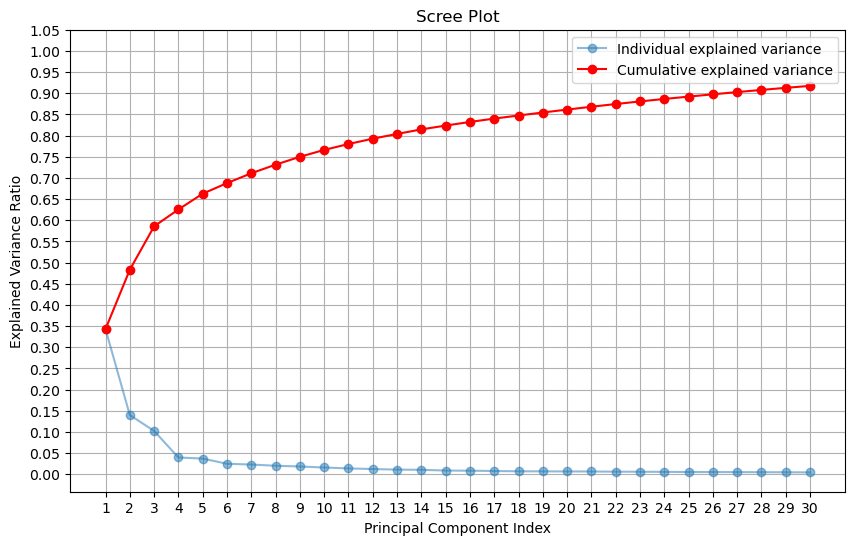

In [440]:
def apply_pca(df, y_column, n_components=None):
    X = df.drop(y_column, axis=1)

    # Use StandardScaler to scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    # Create a new DataFrame with PCA components and the target
    columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
    df_pca = pd.DataFrame(X_pca, columns=columns)
    df_pca[y_column] = df[y_column].values

    return df_pca, pca

def plot_scree(pca):
    var_ratio = pca.explained_variance_ratio_
    cum_var_ratio = var_ratio.cumsum()
    plt.figure(figsize=(10,6))
    plt.plot(range(1, len(var_ratio) + 1), var_ratio, marker='o', linestyle='-', alpha=0.5, label='Individual explained variance')
    plt.plot(range(1, len(cum_var_ratio) + 1), cum_var_ratio, marker='o', color='red', linestyle='-', label='Cumulative explained variance')
    plt.ylabel('Explained Variance Ratio')
    plt.xlabel('Principal Component Index')
    plt.xticks(range(1, len(var_ratio) + 1))
    plt.yticks(np.arange(0, 1.1, 0.05))  # Adjusting y-axis ticks
    plt.grid(True)  # Adding grid
    plt.legend(loc='best')
    plt.title('Scree Plot')
    plt.show()

# Example of usage
df_pca_trial, pca_model_trial = apply_pca(robust_tf_df, 'y', n_components=30)
plot_scree(pca_model_trial)

In [441]:
df_pca_2_comp , pca_model_trial = apply_pca(robust_tf_df, 'y', n_components=2)
df_pca_5_comp , pca_model_trial = apply_pca(robust_tf_df, 'y', n_components=5)
df_pca_10_comp , pca_model_trial = apply_pca(robust_tf_df, 'y', n_components=10)
df_pca_15_comp , pca_model_trial = apply_pca(robust_tf_df, 'y', n_components=15)
df_pca_20_comp , pca_model_trial = apply_pca(robust_tf_df, 'y', n_components=20)

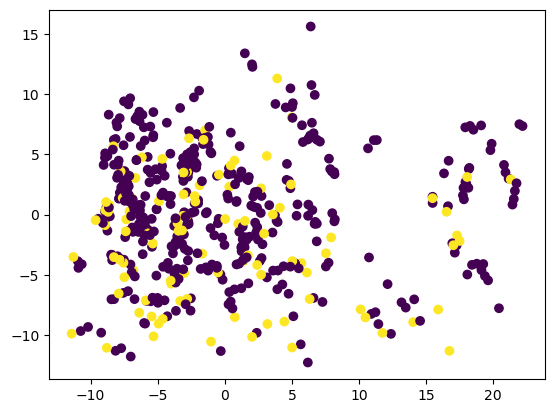

In [442]:
df_pca_2_comp.head()
plt.scatter(x=df_pca_2_comp['PC1'],y=df_pca_2_comp['PC2'],c=df_pca_2_comp['y'])
plt.show()

## Domain Knowledge Ft selection

In [443]:
dm_cols_selected = ['y'
,'Stoch_%K_5'
,'Stoch_Buy_5'
,'Stoch_Sell_5'
,'RSI_5'
,'RSI_Buy_5'
,'RSI_Sell_5'
,'SET_Close'
,'Close_pct_change'
,'Oil_Close'
,'Gold_Close'
,'MACD_Buy'
,'MACD_Sell'
,'SET50_Close'
,'VWAP_25',
 'hour_11_cate',
 'hour_12_cate',
 'hour_14_cate',
 'hour_15_cate',
 'hour_16_cate',
 'day_1_cate',
 'day_2_cate',
 'day_3_cate',
 'day_4_cate',
close_col
]


# k>d == buy

manual_domain_selection_df = robust_tf_df[dm_cols_selected ]
manual_domain_selection_df.head(3)

,y,Stoch_%K_5,Stoch_Buy_5,Stoch_Sell_5,RSI_5,RSI_Buy_5,RSI_Sell_5,SET_Close,Close_pct_change,Oil_Close,Gold_Close,MACD_Buy,MACD_Sell,SET50_Close,VWAP_25,hour_11_cate,hour_12_cate,hour_14_cate,hour_15_cate,hour_16_cate,day_1_cate,day_2_cate,day_3_cate,day_4_cate,ERW.BK_Close
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,
2023-11-16 15:15:00,-1,-0.166663,0,0,-0.036359,0,0,0.312804,0.0,-0.131428,-1.952924,0,0,0.513303,0.684408,False,False,False,True,False,False,False,True,False,1.333334
2023-11-16 15:30:00,-1,-0.166663,0,0,-0.036359,0,0,0.333632,0.0,-0.114284,-1.969157,0,0,0.523672,0.706127,False,False,False,True,False,False,False,True,False,1.333334
2023-11-16 15:45:00,1,0.000005,0,0,-0.036359,0,0,0.414077,0.0,-0.191428,-1.978895,0,0,0.607721,0.737678,False,False,False,True,False,False,False,True,False,1.333334


## Tsnee

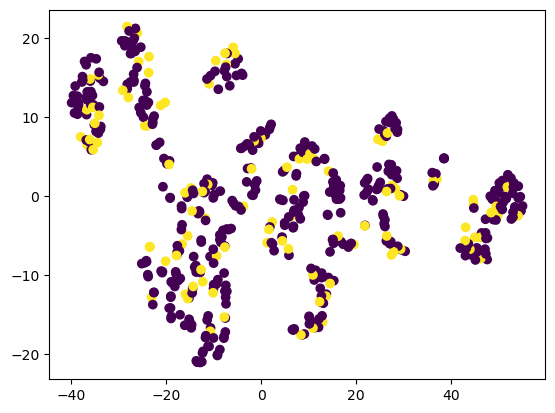

In [444]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def perform_tsne(df, y_col):
    """
    ทำการแปลง t-SNE บนข้อมูลใน pandas DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame ที่มีข้อมูล
    y_col (str): ชื่อคอลัมน์ที่ไม่รวมในการทำ t-SNE

    Returns:
    pd.DataFrame: DataFrame ที่มีผลลัพธ์ของ t-SNE และคอลัมน์ y_col
    """
    # ทำการแยกข้อมูลเป็นส่วนที่ใช้ใน t-SNE และคอลัมน์ y_col
    X = df.drop(y_col, axis=1)
    y = df[y_col]

    # สร้างและฝึกโมเดล t-SNE
    tsne = TSNE(n_components=2)
    tsne_results = tsne.fit_transform(X)

    # สร้าง DataFrame ใหม่จากผลลัพธ์ของ t-SNE และคอลัมน์ y_col
    tsne_df = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'])
    tsne_df[y_col] = df[y_col].values

    return tsne_df

# ตัวอย่างการใช้งานฟังก์ชัน
tsne_df = perform_tsne(robust_tf_df, y_col='y')

plt.figure()
plt.scatter(x=tsne_df['TSNE1'], y=tsne_df['TSNE2'], c=tsne_df['y'])
plt.show()


## Stepwise Ft Selection


In [445]:
def stepwise_selection(df, y_column):
    X = df.drop(y_column, axis=1)
    y = df[y_column]

    models = {
        'LGBM': LGBMClassifier(verbose=-1),
        'GradientBoosting': GradientBoostingClassifier(),
        'RandomForest': RandomForestClassifier(),
        'LogisticRegression_L2': LogisticRegression(penalty='l2', solver='lbfgs'),
        'LogisticRegression_L1': LogisticRegression(penalty='l1', solver='liblinear'),
        'LogisticRegression_ElasticNet': LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5),
        'GaussianNB': GaussianNB(),
        'SVM': SVC()
    }

    selected_features = {}
    model_scores = {}

    for model_name, model in models.items():
        sfs = SFS(model, 
                  k_features=(3, len(X.columns)),  # Range of features to consider
                  forward=True, 
                  floating=True,  # Enable both adding and removing features
                  scoring='roc_auc',
                  cv=5)

        sfs.fit(X, y)
        selected_features[model_name] = X.columns[list(sfs.k_feature_idx_)]
        model_scores[model_name] = sfs.k_score_

    return selected_features, model_scores
  
model_ft_dict = dict()
# Example usage
selected_features_by_model, model_scores = stepwise_selection(manual_domain_selection_df, 'y')
for model, features in selected_features_by_model.items():
    print(f"Selected features for {model}: {features}")
    print(f"Score for {model}: {model_scores[model]}")
    model_ft_dict[model] = list(features)
    print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")


/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/naive_bayes.py:510: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/naive_bayes.py:511: RuntimeWarning: invalid value encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 136, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 471, in _score
    

Selected features for LGBM: Index(['Stoch_%K_5', 'RSI_Buy_5', 'RSI_Sell_5', 'SET50_Close', 'hour_11_cate',
       'hour_12_cate', 'day_3_cate'],
      dtype='object')
Score for LGBM: 0.7097802691828353
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Selected features for GradientBoosting: Index(['Stoch_%K_5', 'RSI_Buy_5', 'RSI_Sell_5', 'MACD_Buy', 'MACD_Sell',
       'hour_11_cate', 'hour_12_cate', 'hour_14_cate', 'day_4_cate'],
      dtype='object')
Score for GradientBoosting: 0.7309178102482031
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Selected features for RandomForest: Index(['Stoch_%K_5', 'RSI_Buy_5', 'RSI_Sell_5', 'MACD_Buy', 'MACD_Sell',
       'hour_11_cate', 'hour_14_cate', 'hour_16_cate', 'day_4_cate'],
      dtype='object')
Score for RandomForest: 0.7170677157645882
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Selected features for LogisticRegre

In [446]:
for k,v in model_ft_dict.items():
    # print(k,v)
    # print(f"""stepwise_{k.lower()}_df = robust_tf_df[model_ft_dict['{k}'] + ['y']] """)
    print(f"""stepwise_{k.lower()}_df""")
stepwise_lgbm_df = robust_tf_df[model_ft_dict['LGBM'] + ['y']]
stepwise_lgbm_df = robust_tf_df[model_ft_dict['LGBM'] + ['y']] 
stepwise_gradientboosting_df = robust_tf_df[model_ft_dict['GradientBoosting'] + ['y']] 
stepwise_randomforest_df = robust_tf_df[model_ft_dict['RandomForest'] + ['y']] 
stepwise_logisticregression_l2_df = robust_tf_df[model_ft_dict['LogisticRegression_L2'] + ['y']] 
stepwise_logisticregression_l1_df = robust_tf_df[model_ft_dict['LogisticRegression_L1'] + ['y']] 
stepwise_logisticregression_elasticnet_df = robust_tf_df[model_ft_dict['LogisticRegression_ElasticNet'] + ['y']] 
stepwise_gaussiannb_df = robust_tf_df[model_ft_dict['GaussianNB'] + ['y']] 
stepwise_svm_df = robust_tf_df[model_ft_dict['SVM'] + ['y']] 

stepwise_lgbm_df
stepwise_gradientboosting_df
stepwise_randomforest_df
stepwise_logisticregression_l2_df
stepwise_logisticregression_l1_df
stepwise_logisticregression_elasticnet_df
stepwise_gaussiannb_df
stepwise_svm_df


# Modeling

In [453]:
# raise SystemExit("Stopping notebook execution")


In [454]:
global summarized_list
summarized_list = []

# Tree Base

### LGBM

In [455]:
# LGBM - Bayesain Opt

def lgbm_bayesian_optimization(df, y_column, ft_nm):
    print(f"{ft_nm} @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
    df[y_column] = df[y_column].replace(-1, 0)
    X = df.drop(y_column, axis=1)
    y = df[y_column]

   # Split the dataset
    # split_index = int(0.8 * len(df))
    X_train = df.loc[:train_split_index].drop(y_column, axis=1)
    y_train = df.loc[:train_split_index][y_column]
    X_test = df.loc[test_split_index: , :].drop(y_column, axis=1)
    y_test = df.loc[test_split_index: , :][y_column]

    tscv = TimeSeriesSplit(n_splits=5)

    def lgbm_evaluate(num_leaves, max_depth, learning_rate, n_estimators, min_child_weight, subsample, colsample_bytree):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            params = {
                'num_leaves': int(num_leaves),
                'max_depth': int(max_depth),
                'learning_rate': learning_rate,
                'n_estimators': int(n_estimators),
                'min_child_weight': min_child_weight,
                'subsample': subsample,
                'colsample_bytree': colsample_bytree,
                'objective': 'binary',
                'verbosity': -1,
                'random_state': 42
            }
            lgbm = LGBMClassifier(**params)
            cv_scores = cross_val_score(lgbm, X_train, y_train, cv=tscv, scoring='roc_auc')
            return np.mean(cv_scores)

    params_bounds = {
        'num_leaves': (20, 100),
        'max_depth': (5, 30),
        'learning_rate': (0.001, 0.5),
        'n_estimators': (50, 500),
        'min_child_weight': (0.001, 10),
        'subsample': (0.5, 1.0),
        'colsample_bytree': (0.5, 1.0)
    }

    lgbm_bo = BayesianOptimization(lgbm_evaluate, params_bounds, random_state=42, verbose=0)
    lgbm_bo.maximize(init_points=5, n_iter=100)

    best_params = lgbm_bo.max['params']
    best_params['num_leaves'] = int(best_params['num_leaves'])
    best_params['max_depth'] = int(best_params['max_depth'])
    best_params['n_estimators'] = int(best_params['n_estimators'])
    best_model = LGBMClassifier(**best_params, objective='binary', verbosity=-1, random_state=42)
    best_model.fit(X_train, y_train)

    cv_scores = cross_val_score(best_model, X_train, y_train, cv=tscv, scoring='roc_auc')
    print("Cross-Validation Scores: ", cv_scores)
    print("Average CV Score: ", np.mean(cv_scores))

    y_train_pred = best_model.predict_proba(X_train)[:, 1]
    train_roc_auc = roc_auc_score(y_train, y_train_pred)
    print(f"Train ROC AUC: {train_roc_auc}")

    y_test_pred = best_model.predict_proba(X_test)[:, 1]
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    print(f"Test ROC AUC: {test_roc_auc}")
    sts = ''
    if train_roc_auc < 0.6 and test_roc_auc < 0.6:
        print("Underfitting detected.")
        sts = "Underfitting"
    elif train_roc_auc > 0.7 and (train_roc_auc - test_roc_auc) > 0.05:
        print("Overfitting detected.")
        sts = "Overfitting"
    else:
        print("Model performance is balanced.")
        sts ="Balanced"

    summarized_list.append( [ft_nm , 'lgbm_bayesian_optimization'  ,train_roc_auc, test_roc_auc ,np.mean(cv_scores), sts])
    print()
    return best_model


lgbm_bayesian_optimization(df_pca_5_comp, 'y','df_pca_5_comp')
lgbm_bayesian_optimization(df_pca_15_comp, 'y','df_pca_15_comp')
lgbm_bayesian_optimization(df_pca_20_comp, 'y','df_pca_20_comp')
lgbm_bayesian_optimization(robust_tf_rfe_df, 'y','robust_tf_rfe_df')
lgbm_bayesian_optimization(robust_tf_ftimp_mulcorr_df, 'y','robust_tf_ftimp_mulcorr_df')
lgbm_bayesian_optimization(manual_domain_selection_df, 'y','manual_domain_selection_df')
lgbm_bayesian_optimization(stepwise_lgbm_df, 'y','stepwise_lgbm_df')
lgbm_bayesian_optimization(stepwise_gradientboosting_df, 'y','stepwise_gradientboosting_df')
lgbm_bayesian_optimization(stepwise_randomforest_df, 'y','stepwise_randomforest_df')
lgbm_bayesian_optimization(stepwise_logisticregression_l2_df, 'y','stepwise_logisticregression_l2_df')
lgbm_bayesian_optimization(stepwise_logisticregression_l1_df, 'y','stepwise_logisticregression_l1_df')
lgbm_bayesian_optimization(stepwise_logisticregression_elasticnet_df, 'y','stepwise_logisticregression_elasticnet_df')
lgbm_bayesian_optimization(stepwise_gaussiannb_df, 'y','stepwise_gaussiannb_df')
lgbm_bayesian_optimization(stepwise_svm_df, 'y','stepwise_svm_df')

df_pca_5_comp @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.5        0.67582418 0.775      0.85185185 0.655     ]
Average CV Score:  0.6915352055352055
Train ROC AUC: 0.8895663956639567
Test ROC AUC: 0.5873789173789175
Overfitting detected.

df_pca_15_comp @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.5        0.56043956 0.71785714 0.75925926 0.66      ]
Average CV Score:  0.6395111925111925
Train ROC AUC: 0.9281842818428184
Test ROC AUC: 0.6515954415954415
Overfitting detected.

df_pca_20_comp @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.5        0.63736264 0.67142857 0.87654321 0.66      ]
Average CV Score:  0.6690668837335505
Train ROC AUC: 1.0
Test ROC AUC: 0.5762962962962964
Overfitting detected.

robust_tf_rfe_df @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

LGBMClassifier(colsample_bytree=0.5273025051813067,
               learning_rate=0.018351203912493414, max_depth=14,
               min_child_weight=1.116527378558273, n_estimators=87,
               num_leaves=89, objective='binary', random_state=42,
               subsample=0.9874905674652806, verbosity=-1)

### Gradient Boosting

In [456]:
def xgb_bayesian_optimization(df, y_column, ft_nm,vb = 0):
    print(f"{ft_nm} @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
    df[y_column] = df[y_column].replace(-1, 0)
    # แยกข้อมูลเป็น features และ target
    X = df.drop(y_column, axis=1)
    y = df[y_column].replace(-1, 0)

   # Split the dataset
    # split_index = int(0.8 * len(df))
    X_train = df.loc[:train_split_index].drop(y_column, axis=1)
    y_train = df.loc[:train_split_index][y_column]
    X_test = df.loc[test_split_index: , :].drop(y_column, axis=1)
    y_test = df.loc[test_split_index: , :][y_column]

    tscv = TimeSeriesSplit(n_splits=5)
    # ฟังก์ชันสำหรับ Cross-Validation และการคำนวณ ROC-AUC
    def xgb_evaluate(max_depth, learning_rate, n_estimators, gamma, min_child_weight, subsample, colsample_bytree):
        params = {'max_depth': int(max_depth),
                  'learning_rate': learning_rate,
                  'n_estimators': int(n_estimators),
                  'gamma': gamma,
                  'min_child_weight': min_child_weight,
                  'subsample': subsample,
                  'colsample_bytree': colsample_bytree,
                  'objective': 'binary:logistic'}
        xgb = XGBClassifier(**params)
        cv_scores = cross_val_score(xgb, X_train, y_train, cv=tscv, scoring='roc_auc')
        return np.mean(cv_scores)

    # กำหนดช่วงของ Hyperparameters
    params_bounds = {
    'max_depth': (3, 150),  # ขยายเป็น 3 ถึง 150
    'learning_rate': (0.001, 0.5),  # ขยายเป็น 0.001 ถึง 0.5
    'n_estimators': (50, 500),  # ขยายเป็น 50 ถึง 500
    'gamma': (0, 10),  # ขยายเป็น 0 ถึง 10
    'min_child_weight': (0, 10),  # ขยายเป็น 0 ถึง 10
    'subsample': (0.5, 1.0),  # ขยายช่วง subsample
    'colsample_bytree': (0.5, 1.0)  # ขยายช่วง colsample_bytree
    }

    # Bayesian Optimization
    xgb_bo = BayesianOptimization(xgb_evaluate, params_bounds, random_state=42, verbose = 0)
    xgb_bo.maximize(init_points=5, n_iter=100 )

    # ใช้โมเดลที่ดีที่สุดบนชุดทดสอบ
    best_params = xgb_bo.max['params']
    best_params['max_depth'] = int(best_params['max_depth'])
    best_params['n_estimators'] = int(best_params['n_estimators'])
    best_model = XGBClassifier(**best_params)
    best_model.fit(X_train, y_train)

    cv_scores = cross_val_score(best_model, X_train, y_train, cv=tscv, scoring='roc_auc')
    print("Cross-Validation Scores: ", cv_scores)
    print("Average CV Score: ", np.mean(cv_scores))

    y_train_pred = best_model.predict_proba(X_train)[:, 1]
    train_roc_auc = roc_auc_score(y_train, y_train_pred)
    print(f"Train ROC AUC: {train_roc_auc}")

    y_test_pred = best_model.predict_proba(X_test)[:, 1]
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    print(f"Test ROC AUC: {test_roc_auc}")
    sts = ''
    if train_roc_auc < 0.6 and test_roc_auc < 0.6:
        print("Underfitting detected.")
        sts = "Underfitting"
    elif train_roc_auc > 0.7 and (train_roc_auc - test_roc_auc) > 0.05:
        print("Overfitting detected.")
        sts = "Overfitting"
    else:
        print("Model performance is balanced.")
        sts ="Balanced"

    summarized_list.append( [ft_nm , 'xgb_bayesian_optimization'  ,train_roc_auc, test_roc_auc ,np.mean(cv_scores), sts])
    print()
    return best_model

xgb_bayesian_optimization(df_pca_5_comp, 'y', 'df_pca_5_comp')
xgb_bayesian_optimization(df_pca_15_comp, 'y', 'df_pca_15_comp')
xgb_bayesian_optimization(df_pca_20_comp, 'y', 'df_pca_20_comp')
xgb_bayesian_optimization(robust_tf_rfe_df, 'y', 'robust_tf_rfe_df')
xgb_bayesian_optimization(robust_tf_ftimp_mulcorr_df, 'y', 'robust_tf_ftimp_mulcorr_df')
xgb_bayesian_optimization(manual_domain_selection_df, 'y', 'manual_domain_selection_df')
xgb_bayesian_optimization(stepwise_lgbm_df, 'y', 'stepwise_lgbm_df')
xgb_bayesian_optimization(stepwise_gradientboosting_df, 'y', 'stepwise_gradientboosting_df')
xgb_bayesian_optimization(stepwise_randomforest_df, 'y', 'stepwise_randomforest_df')
xgb_bayesian_optimization(stepwise_logisticregression_l2_df, 'y', 'stepwise_logisticregression_l2_df')
xgb_bayesian_optimization(stepwise_logisticregression_l1_df, 'y', 'stepwise_logisticregression_l1_df')
xgb_bayesian_optimization(stepwise_logisticregression_elasticnet_df, 'y', 'stepwise_logisticregression_elasticnet_df')
xgb_bayesian_optimization(stepwise_gaussiannb_df, 'y', 'stepwise_gaussiannb_df')
xgb_bayesian_optimization(stepwise_svm_df, 'y', 'stepwise_svm_df')



df_pca_5_comp @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Cross-Validation Scores:  [0.70054945 0.7967033  0.63214286 0.78395062 0.5575    ]
Average CV Score:  0.694169244335911
Train ROC AUC: 0.8970942487202649
Test ROC AUC: 0.5470655270655271
Overfitting detected.

df_pca_15_comp @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.84065934 0.51098901 0.59285714 0.72222222 0.77      ]
Average CV Score:  0.6873455433455434
Train ROC AUC: 1.0
Test ROC AUC: 0.5883190883190884
Overfitting detected.

df_pca_20_comp @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.78846154 0.49725275 0.88928571 0.7037037  0.655     ]
Average CV Score:  0.7067407407407407
Train ROC AUC: 0.9841915085817525
Test ROC AUC: 0.590997150997151
Overfitting detected.

robust_tf_rfe_df @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.72846639 0.583257

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=34, max_leaves=None,
              min_child_weight=0.0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=493, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### Random Forest

In [457]:
def rf_bayesian_optimization(df, y_column, ft_nm,vb = 0):
    print(f"{ft_nm} @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")

    # แยกข้อมูลเป็น features และ target
    df[y_column] = df[y_column].replace(-1, 0)

    X = df.drop(y_column, axis=1)
    y = df[y_column].replace(-1, 0)

   # Split the dataset
    # split_index = int(0.8 * len(df))
    X_train = df.loc[:train_split_index].drop(y_column, axis=1)
    y_train = df.loc[:train_split_index][y_column]
    X_test = df.loc[test_split_index: , :].drop(y_column, axis=1)
    y_test = df.loc[test_split_index: , :][y_column]
    
    tscv = TimeSeriesSplit(n_splits=5)
    # ฟังก์ชันสำหรับ Cross-Validation และการคำนวณ ROC-AUC สำหรับ RandomForest
    def rf_evaluate(n_estimators, max_depth, min_samples_split, min_samples_leaf):
        params = {
            'n_estimators': int(n_estimators),
            'max_depth': int(max_depth),
            'min_samples_split': int(min_samples_split),
            'min_samples_leaf': int(min_samples_leaf),
            'random_state': 42
        }
        rf = RandomForestClassifier(**params)
        tscv = TimeSeriesSplit(n_splits=5)
        cv_scores = cross_val_score(rf, X_train, y_train, cv=tscv, scoring='roc_auc')
        return np.mean(cv_scores)

    # กำหนดช่วงของ Hyperparameters สำหรับ RandomForest
    params_bounds = {
        'n_estimators': (100, 500),
        'max_depth': (10, 50),
        'min_samples_split': (2, 10),
        'min_samples_leaf': (1, 4)
    }

    # Bayesian Optimization
    rf_bo = BayesianOptimization(rf_evaluate, params_bounds, random_state=42, verbose=0)
    rf_bo.maximize(init_points=5, n_iter=100 )

    # ใช้โมเดลที่ดีที่สุดบนชุดทดสอบ
    best_params = rf_bo.max['params']
    best_params['n_estimators'] = int(best_params['n_estimators'])
    best_params['max_depth'] = int(best_params['max_depth'])
    best_params['min_samples_split'] = int(best_params['min_samples_split'])
    best_params['min_samples_leaf'] = int(best_params['min_samples_leaf'])
    best_model = RandomForestClassifier(**best_params)
    best_model.fit(X_train, y_train)

    cv_scores = cross_val_score(best_model, X_train, y_train, cv=tscv, scoring='roc_auc')
    print("Cross-Validation Scores: ", cv_scores)
    print("Average CV Score: ", np.mean(cv_scores))

    y_train_pred = best_model.predict_proba(X_train)[:, 1]
    train_roc_auc = roc_auc_score(y_train, y_train_pred)
    print(f"Train ROC AUC: {train_roc_auc}")

    y_test_pred = best_model.predict_proba(X_test)[:, 1]
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    print(f"Test ROC AUC: {test_roc_auc}")
    sts = ''
    if train_roc_auc < 0.6 and test_roc_auc < 0.6:
        print("Underfitting detected.")
        sts = "Underfitting"
    elif train_roc_auc > 0.7 and (train_roc_auc - test_roc_auc) > 0.05:
        print("Overfitting detected.")
        sts = "Overfitting"
    else:
        print("Model performance is balanced.")
        sts ="Balanced"

    summarized_list.append( [ft_nm , 'rf_bayesian_optimization'  ,train_roc_auc, test_roc_auc ,np.mean(cv_scores), sts])
    print()
    return best_model

rf_bayesian_optimization(df_pca_5_comp, 'y', 'df_pca_5_comp')
rf_bayesian_optimization(df_pca_15_comp, 'y', 'df_pca_15_comp')
rf_bayesian_optimization(df_pca_20_comp, 'y', 'df_pca_20_comp')
rf_bayesian_optimization(robust_tf_rfe_df, 'y', 'robust_tf_rfe_df')
rf_bayesian_optimization(robust_tf_ftimp_mulcorr_df, 'y', 'robust_tf_ftimp_mulcorr_df')
rf_bayesian_optimization(manual_domain_selection_df, 'y', 'manual_domain_selection_df')
rf_bayesian_optimization(stepwise_lgbm_df, 'y', 'stepwise_lgbm_df')
rf_bayesian_optimization(stepwise_gradientboosting_df, 'y', 'stepwise_gradientboosting_df')
rf_bayesian_optimization(stepwise_randomforest_df, 'y', 'stepwise_randomforest_df')
rf_bayesian_optimization(stepwise_logisticregression_l2_df, 'y', 'stepwise_logisticregression_l2_df')
rf_bayesian_optimization(stepwise_logisticregression_l1_df, 'y', 'stepwise_logisticregression_l1_df')
rf_bayesian_optimization(stepwise_logisticregression_elasticnet_df, 'y', 'stepwise_logisticregression_elasticnet_df')
rf_bayesian_optimization(stepwise_gaussiannb_df, 'y', 'stepwise_gaussiannb_df')
rf_bayesian_optimization(stepwise_svm_df, 'y', 'stepwise_svm_df')

df_pca_5_comp @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.74450549 0.8021978  0.44285714 0.83333333 0.695     ]
Average CV Score:  0.7035787545787545
Train ROC AUC: 0.9844926227040048
Test ROC AUC: 0.5862108262108262
Overfitting detected.

df_pca_15_comp @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.80769231 0.54395604 0.50714286 0.71604938 0.71      ]
Average CV Score:  0.6569681183014516
Train ROC AUC: 0.9996988858777477
Test ROC AUC: 0.6396011396011396
Overfitting detected.

df_pca_20_comp @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.86263736 0.40384615 0.53571429 0.7037037  0.73      ]
Average CV Score:  0.6471803011803012
Train ROC AUC: 1.0
Test ROC AUC: 0.6204558404558406
Overfitting detected.

robust_tf_rfe_df @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

RandomForestClassifier(max_depth=14, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=414)

# Logistic Regression


In [458]:
df_pca_5_comp , pca_model_trial = apply_pca(robust_tf_df, 'y', n_components=5)
df_pca_10_comp , pca_model_trial = apply_pca(robust_tf_df, 'y', n_components=10)
df_pca_15_comp , pca_model_trial = apply_pca(robust_tf_df, 'y', n_components=15)
df_pca_20_comp , pca_model_trial = apply_pca(robust_tf_df, 'y', n_components=20)

### L1

In [459]:
def logistic_regression_bayesian_optimization_l1(df, y_column, ft_nm,vb = 0):
    print(f"{ft_nm} @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")

    df[y_column] = df[y_column].replace(-1, 0)

    # แยกข้อมูลเป็น features และ target
    X = df.drop(y_column, axis=1)
    y = df[y_column].replace(-1, 0)

    # Split the dataset
    # split_index = int(0.8 * len(df))
    X_train = df.loc[:train_split_index].drop(y_column, axis=1)
    y_train = df.loc[:train_split_index][y_column]
    X_test = df.loc[test_split_index: , :].drop(y_column, axis=1)
    y_test = df.loc[test_split_index: , :][y_column]
    tscv = TimeSeriesSplit(n_splits=5)

    def logistic_evaluate(C):
        params = {
            'penalty': 'l1',
            'C': C,
            'solver': 'saga',
            'max_iter': 1000000,
            'random_state': 42
        }
        logistic = LogisticRegression(**params)
        cv_scores = cross_val_score(logistic, X_train, y_train, cv=tscv, scoring='roc_auc')
        return np.mean(cv_scores)

    # กำหนดช่วงของ Hyperparameters
    params_bounds = {
        'C': (0.001, 10000)
    }

    # Bayesian Optimization
    logistic_bo = BayesianOptimization(logistic_evaluate, params_bounds, random_state=42, allow_duplicate_points=True, verbose=0)
    logistic_bo.maximize(init_points=5, n_iter=100)

    # ใช้โมเดลที่ดีที่สุดบนชุดทดสอบ
    best_params = logistic_bo.max['params']
    best_params['penalty'] = 'l1'
    best_params['solver'] = 'saga'
    best_model = LogisticRegression(**best_params)
    best_model.fit(X_train, y_train)

    cv_scores = cross_val_score(best_model, X_train, y_train, cv=tscv, scoring='roc_auc')
    print("Cross-Validation Scores: ", cv_scores)
    print("Average CV Score: ", np.mean(cv_scores))

    y_train_pred = best_model.predict_proba(X_train)[:, 1]
    train_roc_auc = roc_auc_score(y_train, y_train_pred)
    print(f"Train ROC AUC: {train_roc_auc}")

    y_test_pred = best_model.predict_proba(X_test)[:, 1]
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    print(f"Test ROC AUC: {test_roc_auc}")
    sts = ''
    if train_roc_auc < 0.6 and test_roc_auc < 0.6:
        print("Underfitting detected.")
        sts = "Underfitting"
    elif train_roc_auc > 0.7 and (train_roc_auc - test_roc_auc) > 0.05:
        print("Overfitting detected.")
        sts = "Overfitting"
    else:
        print("Model performance is balanced.")
        sts ="Balanced"

    summarized_list.append( [ft_nm , 'logistic_regression_bayesian_optimization_l1'  ,train_roc_auc, test_roc_auc ,np.mean(cv_scores), sts])
    print()
    return best_model

logistic_regression_bayesian_optimization_l1(df_pca_5_comp, 'y', 'df_pca_5_comp')
logistic_regression_bayesian_optimization_l1(df_pca_15_comp, 'y', 'df_pca_15_comp')
logistic_regression_bayesian_optimization_l1(df_pca_20_comp, 'y', 'df_pca_20_comp')
logistic_regression_bayesian_optimization_l1(robust_tf_rfe_df, 'y', 'robust_tf_rfe_df')
logistic_regression_bayesian_optimization_l1(robust_tf_ftimp_mulcorr_df, 'y', 'robust_tf_ftimp_mulcorr_df')
logistic_regression_bayesian_optimization_l1(manual_domain_selection_df, 'y', 'manual_domain_selection_df')
logistic_regression_bayesian_optimization_l1(stepwise_lgbm_df, 'y', 'stepwise_lgbm_df')
logistic_regression_bayesian_optimization_l1(stepwise_gradientboosting_df, 'y', 'stepwise_gradientboosting_df')
logistic_regression_bayesian_optimization_l1(stepwise_randomforest_df, 'y', 'stepwise_randomforest_df')
logistic_regression_bayesian_optimization_l1(stepwise_logisticregression_l2_df, 'y', 'stepwise_logisticregression_l2_df')
logistic_regression_bayesian_optimization_l1(stepwise_logisticregression_l1_df, 'y', 'stepwise_logisticregression_l1_df')
logistic_regression_bayesian_optimization_l1(stepwise_logisticregression_elasticnet_df, 'y', 'stepwise_logisticregression_elasticnet_df')
logistic_regression_bayesian_optimization_l1(stepwise_gaussiannb_df, 'y', 'stepwise_gaussiannb_df')
logistic_regression_bayesian_optimization_l1(stepwise_svm_df, 'y', 'stepwise_svm_df')

df_pca_5_comp @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Cross-Validation Scores:  [0.78021978 0.78571429 0.79285714 0.7962963  0.725     ]
Average CV Score:  0.776017501017501
Train ROC AUC: 0.7685937970490816
Test ROC AUC: 0.6506552706552707
Overfitting detected.

df_pca_15_comp @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Cross-Validation Scores:  [0.82967033 0.5989011  0.57142857 0.87654321 0.86      ]
Average CV Score:  0.7473086419753086
Train ROC AUC: 0.823998795543511
Test ROC AUC: 0.6213675213675214
Overfitting detected.

df_pca_20_comp @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Cross-Validation Scores:  [0.75274725 0.78021978 0.75714286 0.80246914 0.81      ]
Average CV Score:  0.7805158051824719
Train ROC AUC: 0.8336344474555857
Test ROC AUC: 0.6571509971509972
Overfitting detected.

robust_tf_rfe_df @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Cross-Validation Scores:  [0.79306723 0.66515837 0.58613445 0.61085973 0.69924812]
Average CV Score:  0.6708935801041064
Train ROC AUC: 0.7457070707070707
Test ROC AUC: 0.8333333333333334
Model performance is balanced.

robust_tf_ftimp_mulcorr_df @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Cross-Validation Scores:  [0.78256303 0.7158371  0.58718487 0.5918552  0.70760234]
Average CV Score:  0.6770085092066517
Train ROC AUC: 0.7369949494949495
Test ROC AUC: 0.7407407407407407
Model performance is balanced.

manual_domain_selection_df @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Cross-Validation Scores:  [0.81092437 0.62533937 0.57352941 0.62895928 0.6374269 ]
Average CV Score:  0.6552358649262674
Train ROC AUC: 0.749520202020202
Test ROC AUC: 0.7175925925925926
Model performance is balanced.

stepwise_lgbm_df @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Cross-Validation Scores:  [0.71218487 0.69049774 0.61029412 0.61538462 0.70342523]
Average CV Score:  0.6663573148557669
Train ROC AUC: 0.7232954545454545
Test ROC AUC: 0.7638888888888888
Model performance is balanced.

stepwise_gradientboosting_df @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Cross-Validation Scores:  [0.77310924 0.67737557 0.56144958 0.67285068 0.71177945]
Average CV Score:  0.6793129032989714
Train ROC AUC: 0.7246085858585859
Test ROC AUC: 0.7314814814814814
Model performance is balanced.

stepwise_randomforest_df @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Cross-Validation Scores:  [0.76365546 0.67285068 0.57090336 0.7081448  0.70885547]
Average CV Score:  0.6848819541311801
Train ROC AUC: 0.7217550505050505
Test ROC AUC: 0.7268518518518517
Model performance is balanced.

stepwise_logisticregression_l2_df @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Cross-Validation Scores:  [0.83823529 0.67963801 0.57878151 0.71312217 0.74018379]
Average CV Score:  0.7099921561067072
Train ROC AUC: 0.7278030303030302
Test ROC AUC: 0.7916666666666667
Model performance is balanced.

stepwise_logisticregression_l1_df @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Cross-Validation Scores:  [0.81932773 0.69683258 0.5987395  0.65158371 0.78863826]
Average CV Score:  0.7110243557611978
Train ROC AUC: 0.7244570707070707
Test ROC AUC: 0.7314814814814814
Model performance is balanced.

stepwise_logisticregression_elasticnet_df @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Cross-Validation Scores:  [0.83928571 0.6760181  0.56617647 0.70135747 0.732665  ]
Average CV Score:  0.70310054926154
Train ROC AUC: 0.7247474747474748
Test ROC AUC: 0.7916666666666667
Model performance is balanced.

stepwise_gaussiannb_df @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Cross-Validation Scores:  [0.75840336 0.62352941 0.61869748 0.69411765 0.732665  ]
Average CV Score:  0.6854825789965109
Train ROC AUC: 0.7286363636363636
Test ROC AUC: 0.8101851851851851
Model performance is balanced.

stepwise_svm_df @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.77521008 0.61538462 0.52836134 0.68868778 0.7101086 ]
Average CV Score:  0.6635504863213841
Train ROC AUC: 0.7220707070707071
Test ROC AUC: 0.7314814814814815
Model performance is balanced.



/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=3745.4018139335058, penalty='l1', solver='saga')

### L2

In [460]:
def logistic_regression_bayesian_optimization_l2(df, y_column, ft_nm,vb = 0):
    print(f"{ft_nm} @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")

    df[y_column] = df[y_column].replace(-1, 0)

    # แยกข้อมูลเป็น features และ target
    X = df.drop(y_column, axis=1)
    y = df[y_column].replace(-1, 0)

   # Split the dataset
    # split_index = int(0.8 * len(df))
    X_train = df.loc[:train_split_index].drop(y_column, axis=1)
    y_train = df.loc[:train_split_index][y_column]
    X_test = df.loc[test_split_index: , :].drop(y_column, axis=1)
    y_test = df.loc[test_split_index: , :][y_column]
    tscv = TimeSeriesSplit(n_splits=5)

    def logistic_evaluate(C):
        params = {
            'penalty': 'l2',
            'C': C,
            'solver': 'lbfgs',
            'max_iter': 1000000,
            'random_state': 42
        }
        logistic = LogisticRegression(**params)
        cv_scores = cross_val_score(logistic, X_train, y_train, cv=tscv, scoring='roc_auc')
        return np.mean(cv_scores)

    # กำหนดช่วงของ Hyperparameters
    params_bounds = {
        'C': (0.001, 10000)
    }

    # Bayesian Optimization
    logistic_bo = BayesianOptimization(logistic_evaluate, params_bounds, random_state=42, allow_duplicate_points=True, verbose=0)
    logistic_bo.maximize(init_points=5, n_iter=100)

    # ใช้โมเดลที่ดีที่สุดบนชุดทดสอบ
    best_params = logistic_bo.max['params']
    best_params['penalty'] = 'l2'
    best_params['solver'] = 'lbfgs'
    best_model = LogisticRegression(**best_params)
    best_model.fit(X_train, y_train)

    cv_scores = cross_val_score(best_model, X_train, y_train, cv=tscv, scoring='roc_auc')
    print("Cross-Validation Scores: ", cv_scores)
    print("Average CV Score: ", np.mean(cv_scores))

    y_train_pred = best_model.predict_proba(X_train)[:, 1]
    train_roc_auc = roc_auc_score(y_train, y_train_pred)
    print(f"Train ROC AUC: {train_roc_auc}")

    y_test_pred = best_model.predict_proba(X_test)[:, 1]
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    print(f"Test ROC AUC: {test_roc_auc}")
    sts = ''
    if train_roc_auc < 0.6 and test_roc_auc < 0.6:
        print("Underfitting detected.")
        sts = "Underfitting"
    elif train_roc_auc > 0.7 and (train_roc_auc - test_roc_auc) > 0.05:
        print("Overfitting detected.")
        sts = "Overfitting"
    else:
        print("Model performance is balanced.")
        sts ="Balanced"

    summarized_list.append( [ft_nm , 'logistic_regression_bayesian_optimization_l2'  ,train_roc_auc, test_roc_auc ,np.mean(cv_scores), sts])
    print()
    return best_model

logistic_regression_bayesian_optimization_l2(df_pca_5_comp, 'y', 'df_pca_5_comp')
logistic_regression_bayesian_optimization_l2(df_pca_15_comp, 'y', 'df_pca_15_comp')
logistic_regression_bayesian_optimization_l2(df_pca_20_comp, 'y', 'df_pca_20_comp')
logistic_regression_bayesian_optimization_l2(robust_tf_rfe_df, 'y', 'robust_tf_rfe_df')
logistic_regression_bayesian_optimization_l2(robust_tf_ftimp_mulcorr_df, 'y', 'robust_tf_ftimp_mulcorr_df')
logistic_regression_bayesian_optimization_l2(manual_domain_selection_df, 'y', 'manual_domain_selection_df')
logistic_regression_bayesian_optimization_l2(stepwise_lgbm_df, 'y', 'stepwise_lgbm_df')
logistic_regression_bayesian_optimization_l2(stepwise_gradientboosting_df, 'y', 'stepwise_gradientboosting_df')
logistic_regression_bayesian_optimization_l2(stepwise_randomforest_df, 'y', 'stepwise_randomforest_df')
logistic_regression_bayesian_optimization_l2(stepwise_logisticregression_l2_df, 'y', 'stepwise_logisticregression_l2_df')
logistic_regression_bayesian_optimization_l2(stepwise_logisticregression_l1_df, 'y', 'stepwise_logisticregression_l1_df')
logistic_regression_bayesian_optimization_l2(stepwise_logisticregression_elasticnet_df, 'y', 'stepwise_logisticregression_elasticnet_df')
logistic_regression_bayesian_optimization_l2(stepwise_gaussiannb_df, 'y', 'stepwise_gaussiannb_df')
logistic_regression_bayesian_optimization_l2(stepwise_svm_df, 'y', 'stepwise_svm_df')

df_pca_5_comp @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.81318681 0.78571429 0.83571429 0.7962963  0.695     ]
Average CV Score:  0.7851823361823362
Train ROC AUC: 0.7684432399879555
Test ROC AUC: 0.6544159544159545
Overfitting detected.

df_pca_15_comp @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.81868132 0.67582418 0.56428571 0.87037037 0.855     ]
Average CV Score:  0.7568323158323158
Train ROC AUC: 0.8259560373381511
Test ROC AUC: 0.6257549857549858
Overfitting detected.

df_pca_20_comp @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

Cross-Validation Scores:  [0.76373626 0.71428571 0.54285714 0.82098765 0.775     ]
Average CV Score:  0.7233733550400216
Train ROC AUC: 0.8477868112014454
Test ROC AUC: 0.6304843304843305
Overfitting detected.

robust_tf_rfe_df @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

Cross-Validation Scores:  [0.78151261 0.69321267 0.57352941 0.58099548 0.69172932]
Average CV Score:  0.6641958969822748
Train ROC AUC: 0.7511868686868687
Test ROC AUC: 0.7962962962962963
Model performance is balanced.

robust_tf_ftimp_mulcorr_df @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

Cross-Validation Scores:  [0.77521008 0.73393665 0.60714286 0.5918552  0.71595656]
Average CV Score:  0.6848202708883824
Train ROC AUC: 0.7437878787878789
Test ROC AUC: 0.7314814814814814
Model performance is balanced.

manual_domain_selection_df @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

Cross-Validation Scores:  [0.82668067 0.60361991 0.54726891 0.64253394 0.65246449]
Average CV Score:  0.6545135841111074
Train ROC AUC: 0.7556565656565657
Test ROC AUC: 0.75
Model performance is balanced.

stepwise_lgbm_df @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.75840336 0.68868778 0.6197479  0.67963801 0.69256475]
Average CV Score:  0.6878083595111458
Train ROC AUC: 0.7176388888888889
Test ROC AUC: 0.8333333333333334
Model performance is balanced.

stepwise_gradientboosting_df @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.83193277 0.66832579 0.63707983 0.67285068 0.70008354]
Average CV Score:  0.7020545235638115
Train ROC AUC: 0.721679292929293
Test ROC AUC: 0.763888888888889
Model performance is balanced.

stepwise_randomforest_df @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

LogisticRegression(C=3745.4018139335058)

## Elastic net

In [461]:
def logistic_regression_bayesian_optimization_elasticnet(df, y_column, ft_nm,vb = 0):
    df[y_column] = df[y_column].replace(-1, 0)

    # แยกข้อมูลเป็น features และ target
    X = df.drop(y_column, axis=1)
    y = df[y_column].replace(-1, 0)

    # Split the dataset
    # split_index = int(0.8 * len(df))
    X_train = df.loc[:train_split_index].drop(y_column, axis=1)
    y_train = df.loc[:train_split_index][y_column]
    X_test = df.loc[test_split_index: , :].drop(y_column, axis=1)
    y_test = df.loc[test_split_index: , :][y_column]
    tscv = TimeSeriesSplit(n_splits=5)

    def logistic_evaluate(C, l1_ratio):
        params = {
            'penalty': 'elasticnet',
            'C': C,
            'solver': 'saga',  # Solver ที่รองรับ elasticnet
            'l1_ratio': l1_ratio,
            'max_iter': 1000000,
            'random_state': 42
        }
        logistic = LogisticRegression(**params)
        cv_scores = cross_val_score(logistic, X_train, y_train, cv=tscv, scoring='roc_auc')
        return np.mean(cv_scores)

    # กำหนดช่วงของ Hyperparameters
    params_bounds = {
        'C': (0.001, 10000),
        'l1_ratio': (0, 1)  # ช่วงของ l1_ratio สำหรับ elasticnet
    }

    # Bayesian Optimization
    logistic_bo = BayesianOptimization(logistic_evaluate, params_bounds, random_state=42, allow_duplicate_points=True, verbose=0)
    logistic_bo.maximize(init_points=5, n_iter=100)

    # ใช้โมเดลที่ดีที่สุดบนชุดทดสอบ
    best_params = logistic_bo.max['params']
    best_params['penalty'] = 'elasticnet'
    best_params['solver'] = 'saga'
    best_model = LogisticRegression(**best_params)
    best_model.fit(X_train, y_train)

    cv_scores = cross_val_score(best_model, X_train, y_train, cv=tscv, scoring='roc_auc')
    print("Cross-Validation Scores: ", cv_scores)
    print("Average CV Score: ", np.mean(cv_scores))

    y_train_pred = best_model.predict_proba(X_train)[:, 1]
    train_roc_auc = roc_auc_score(y_train, y_train_pred)
    print(f"Train ROC AUC: {train_roc_auc}")

    y_test_pred = best_model.predict_proba(X_test)[:, 1]
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    print(f"Test ROC AUC: {test_roc_auc}")
    sts = ''
    if train_roc_auc < 0.6 and test_roc_auc < 0.6:
        print("Underfitting detected.")
        sts = "Underfitting"
    elif train_roc_auc > 0.7 and (train_roc_auc - test_roc_auc) > 0.05:
        print("Overfitting detected.")
        sts = "Overfitting"
    else:
        print("Model performance is balanced.")
        sts ="Balanced"

    summarized_list.append( [ft_nm , 'logistic_regression_bayesian_optimization_elasticnet'  ,train_roc_auc, test_roc_auc ,np.mean(cv_scores), sts])
    print()
    return best_model

logistic_regression_bayesian_optimization_elasticnet(df_pca_5_comp, 'y', 'df_pca_5_comp')
logistic_regression_bayesian_optimization_elasticnet(df_pca_15_comp, 'y', 'df_pca_15_comp')
logistic_regression_bayesian_optimization_elasticnet(df_pca_20_comp, 'y', 'df_pca_20_comp')
logistic_regression_bayesian_optimization_elasticnet(robust_tf_rfe_df, 'y', 'robust_tf_rfe_df')
logistic_regression_bayesian_optimization_elasticnet(robust_tf_ftimp_mulcorr_df, 'y', 'robust_tf_ftimp_mulcorr_df')
logistic_regression_bayesian_optimization_elasticnet(manual_domain_selection_df, 'y', 'manual_domain_selection_df')
logistic_regression_bayesian_optimization_elasticnet(stepwise_lgbm_df, 'y', 'stepwise_lgbm_df')
logistic_regression_bayesian_optimization_elasticnet(stepwise_gradientboosting_df, 'y', 'stepwise_gradientboosting_df')
logistic_regression_bayesian_optimization_elasticnet(stepwise_randomforest_df, 'y', 'stepwise_randomforest_df')
logistic_regression_bayesian_optimization_elasticnet(stepwise_logisticregression_l2_df, 'y', 'stepwise_logisticregression_l2_df')
logistic_regression_bayesian_optimization_elasticnet(stepwise_logisticregression_l1_df, 'y', 'stepwise_logisticregression_l1_df')
logistic_regression_bayesian_optimization_elasticnet(stepwise_logisticregression_elasticnet_df, 'y', 'stepwise_logisticregression_elasticnet_df')
logistic_regression_bayesian_optimization_elasticnet(stepwise_gaussiannb_df, 'y', 'stepwise_gaussiannb_df')
logistic_regression_bayesian_optimization_elasticnet(stepwise_svm_df, 'y', 'stepwise_svm_df')




/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Cross-Validation Scores:  [0.78571429 0.78571429 0.79285714 0.7962963  0.725     ]
Average CV Score:  0.7771164021164021
Train ROC AUC: 0.7684432399879554
Test ROC AUC: 0.650997150997151
Overfitting detected.



/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Cross-Validation Scores:  [0.83516484 0.62637363 0.57142857 0.88888889 0.86      ]
Average CV Score:  0.7563711843711843
Train ROC AUC: 0.8247515808491418
Test ROC AUC: 0.6246153846153846
Overfitting detected.



/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Cross-Validation Scores:  [0.86263736 0.7032967  0.57857143 0.83333333 0.785     ]
Average CV Score:  0.7525677655677656
Train ROC AUC: 0.8477868112014453
Test ROC AUC: 0.6360113960113961
Overfitting detected.



/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Cross-Validation Scores:  [0.7762605  0.65882353 0.59033613 0.61719457 0.70676692]
Average CV Score:  0.6698763310992413
Train ROC AUC: 0.7454292929292928
Test ROC AUC: 0.8379629629629629
Model performance is balanced.



/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Cross-Validation Scores:  [0.78361345 0.71674208 0.58613445 0.5918552  0.70927318]
Average CV Score:  0.6775236734369863
Train ROC AUC: 0.7365404040404041
Test ROC AUC: 0.7407407407407407
Model performance is balanced.



/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Cross-Validation Scores:  [0.81302521 0.62443439 0.57352941 0.6280543  0.6374269 ]
Average CV Score:  0.655294042043268
Train ROC AUC: 0.7494191919191919
Test ROC AUC: 0.7175925925925926
Model performance is balanced.

Cross-Validation Scores:  [0.82878151 0.66199095 0.60504202 0.67239819 0.6984127 ]
Average CV Score:  0.6933250736191914
Train ROC AUC: 0.7194065656565658
Test ROC AUC: 0.8333333333333334
Model performance is balanced.

Cross-Validation Scores:  [0.83035714 0.6678733  0.625      0.67737557 0.70718463]
Average CV Score:  0.7015581279745366
Train ROC AUC: 0.7210353535353535
Test ROC AUC: 0.7638888888888888
Model performance is balanced.



/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Cross-Validation Scores:  [0.76365546 0.67285068 0.57090336 0.7081448  0.70885547]
Average CV Score:  0.6848819541311801
Train ROC AUC: 0.7217550505050505
Test ROC AUC: 0.7268518518518517
Model performance is balanced.



/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Cross-Validation Scores:  [0.83298319 0.6841629  0.57773109 0.71131222 0.74185464]
Average CV Score:  0.7096088070855873
Train ROC AUC: 0.7278787878787878
Test ROC AUC: 0.7916666666666667
Model performance is balanced.



/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Cross-Validation Scores:  [0.81932773 0.69683258 0.5987395  0.65158371 0.78863826]
Average CV Score:  0.7110243557611978
Train ROC AUC: 0.7244570707070707
Test ROC AUC: 0.7314814814814814
Model performance is balanced.



/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Cross-Validation Scores:  [0.84033613 0.68054299 0.56722689 0.70135747 0.73433584]
Average CV Score:  0.7047598634595539
Train ROC AUC: 0.724419191919192
Test ROC AUC: 0.7916666666666667
Model performance is balanced.



/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Cross-Validation Scores:  [0.75735294 0.62352941 0.61869748 0.69411765 0.732665  ]
Average CV Score:  0.6852724949628974
Train ROC AUC: 0.7285101010101009
Test ROC AUC: 0.8055555555555556
Model performance is balanced.

Cross-Validation Scores:  [0.77415966 0.61538462 0.52836134 0.68959276 0.7101086 ]
Average CV Score:  0.6635213977628838
Train ROC AUC: 0.7220707070707071
Test ROC AUC: 0.7314814814814815
Model performance is balanced.



/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/narischanpaiboonkit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=580.9204627115457, l1_ratio=0.1115122123212764,
                   penalty='elasticnet', solver='saga')

# SVM

In [462]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from bayes_opt import BayesianOptimization
import numpy as np
import warnings

def svm_bayesian_optimization(df, y_column, ft_nm, vb=0):
    print(f"{ft_nm} @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
    df[y_column] = df[y_column].replace(-1, 0)

    X = df.drop(y_column, axis=1)
    y = df[y_column]

   # Split the dataset
    # split_index = int(0.8 * len(df))
    X_train = df.loc[:train_split_index].drop(y_column, axis=1)
    y_train = df.loc[:train_split_index][y_column]
    X_test = df.loc[test_split_index: , :].drop(y_column, axis=1)
    y_test = df.loc[test_split_index: , :][y_column]

    tscv = TimeSeriesSplit(n_splits=5)

    def svm_evaluate(C, gamma):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            params = {'C': C, 'gamma': gamma, 'kernel': 'rbf'}
            svm = SVC(**params, probability=True, random_state=42)
            cv_scores = cross_val_score(svm, X_train, y_train, cv=tscv, scoring='roc_auc')
            return np.mean(cv_scores)

    params_bounds = {'C': (0.1, 100), 'gamma': (0.001, 1)}

    svm_bo = BayesianOptimization(svm_evaluate, params_bounds, random_state=42, verbose=vb)
    svm_bo.maximize(init_points=5, n_iter=100)

    best_params = svm_bo.max['params']
    best_model = SVC(**best_params, kernel='rbf', probability=True, random_state=42)
    best_model.fit(X_train, y_train)

    cv_scores = cross_val_score(best_model, X_train, y_train, cv=tscv, scoring='roc_auc')
    print("Cross-Validation Scores: ", cv_scores)
    print("Average CV Score: ", np.mean(cv_scores))

    y_train_pred = best_model.decision_function(X_train)
    train_roc_auc = roc_auc_score(y_train, y_train_pred)
    print(f"Train ROC AUC: {train_roc_auc}")

    y_test_pred = best_model.decision_function(X_test)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    print(f"Test ROC AUC: {test_roc_auc}")

    sts = 'Underfitting' if train_roc_auc < 0.6 and test_roc_auc < 0.6 else 'Overfitting' if train_roc_auc > 0.7 and (train_roc_auc - test_roc_auc) > 0.05 else 'Balanced'
    print(sts)

    summarized_list.append([ft_nm, 'svm_bayesian_optimization', train_roc_auc, test_roc_auc, np.mean(cv_scores), sts])
    print()

    return best_model


svm_bayesian_optimization(df_pca_5_comp, 'y', 'df_pca_5_comp')
svm_bayesian_optimization(df_pca_15_comp, 'y', 'df_pca_15_comp')
svm_bayesian_optimization(df_pca_20_comp, 'y', 'df_pca_20_comp')
svm_bayesian_optimization(robust_tf_rfe_df, 'y', 'robust_tf_rfe_df')
svm_bayesian_optimization(robust_tf_ftimp_mulcorr_df, 'y', 'robust_tf_ftimp_mulcorr_df')
svm_bayesian_optimization(manual_domain_selection_df, 'y', 'manual_domain_selection_df')
svm_bayesian_optimization(stepwise_lgbm_df, 'y', 'stepwise_lgbm_df')
svm_bayesian_optimization(stepwise_gradientboosting_df, 'y', 'stepwise_gradientboosting_df')
svm_bayesian_optimization(stepwise_randomforest_df, 'y', 'stepwise_randomforest_df')
svm_bayesian_optimization(stepwise_logisticregression_l2_df, 'y', 'stepwise_logisticregression_l2_df')
svm_bayesian_optimization(stepwise_logisticregression_l1_df, 'y', 'stepwise_logisticregression_l1_df')
svm_bayesian_optimization(stepwise_logisticregression_elasticnet_df, 'y', 'stepwise_logisticregression_elasticnet_df')
svm_bayesian_optimization(stepwise_gaussiannb_df, 'y', 'stepwise_gaussiannb_df')
svm_bayesian_optimization(stepwise_svm_df, 'y', 'stepwise_svm_df')


df_pca_5_comp @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.8021978  0.73626374 0.79285714 0.7345679  0.605     ]
Average CV Score:  0.7341773165106498
Train ROC AUC: 0.7496236073471847
Test ROC AUC: 0.6557264957264957
Overfitting

df_pca_15_comp @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.82967033 0.70879121 0.75       0.75308642 0.765     ]
Average CV Score:  0.7613095916429249
Train ROC AUC: 0.9921710328214394
Test ROC AUC: 0.5692307692307692
Overfitting

df_pca_20_comp @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.84615385 0.69230769 0.69285714 0.82098765 0.79      ]
Average CV Score:  0.7684612671279338
Train ROC AUC: 0.9206564287865101
Test ROC AUC: 0.6293447293447294
Overfitting

robust_tf_rfe_df @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

SVC(C=12.87770657011458, gamma=0.3955972652811808, probability=True,
    random_state=42)

# Gaussian NB

In [463]:
def gaussian_naive_bayes(df, y_column, ft_nm,vb = 0):
    print(f"{ft_nm} @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")

    df[y_column] = df[y_column].replace(-1, 0)

    # Split data into features and target
    X = df.drop(y_column, axis=1)
    y = df[y_column]

    # Split the dataset
    # split_index = int(0.8 * len(df))
    X_train = df.loc[:train_split_index].drop(y_column, axis=1)
    y_train = df.loc[:train_split_index][y_column]
    X_test = df.loc[test_split_index: , :].drop(y_column, axis=1)
    y_test = df.loc[test_split_index: , :][y_column]

    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)

    # Create Gaussian Naive Bayes model and adjust var_smoothing
    gnb = GaussianNB(var_smoothing=1e-9)
    best_model = gnb
    best_model.fit(X_train, y_train)

    cv_scores = cross_val_score(best_model, X_train, y_train, cv=tscv, scoring='roc_auc')
    print("Cross-Validation Scores: ", cv_scores)
    print("Average CV Score: ", np.mean(cv_scores))

    y_train_pred = best_model.predict_proba(X_train)[:, 1]
    train_roc_auc = roc_auc_score(y_train, y_train_pred)
    print(f"Train ROC AUC: {train_roc_auc}")

    y_test_pred = best_model.predict_proba(X_test)[:, 1]
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    print(f"Test ROC AUC: {test_roc_auc}")
    sts = ''
    if train_roc_auc < 0.6 and test_roc_auc < 0.6:
        print("Underfitting detected.")
        sts = "Underfitting"
    elif train_roc_auc > 0.7 and (train_roc_auc - test_roc_auc) > 0.05:
        print("Overfitting detected.")
        sts = "Overfitting"
    else:
        print("Model performance is balanced.")
        sts ="Balanced"

    summarized_list.append( [ft_nm , 'gaussian_naive_bayes'  ,train_roc_auc, test_roc_auc ,np.mean(cv_scores), sts])
    print()

    return gnb


gaussian_naive_bayes(df_pca_5_comp, 'y', 'df_pca_5_comp')
gaussian_naive_bayes(df_pca_15_comp, 'y', 'df_pca_15_comp')
gaussian_naive_bayes(df_pca_20_comp, 'y', 'df_pca_20_comp')
gaussian_naive_bayes(robust_tf_rfe_df, 'y', 'robust_tf_rfe_df')
gaussian_naive_bayes(robust_tf_ftimp_mulcorr_df, 'y', 'robust_tf_ftimp_mulcorr_df')
gaussian_naive_bayes(manual_domain_selection_df, 'y', 'manual_domain_selection_df')
gaussian_naive_bayes(stepwise_lgbm_df, 'y', 'stepwise_lgbm_df')
gaussian_naive_bayes(stepwise_gradientboosting_df, 'y', 'stepwise_gradientboosting_df')
gaussian_naive_bayes(stepwise_randomforest_df, 'y', 'stepwise_randomforest_df')
gaussian_naive_bayes(stepwise_logisticregression_l2_df, 'y', 'stepwise_logisticregression_l2_df')
gaussian_naive_bayes(stepwise_logisticregression_l1_df, 'y', 'stepwise_logisticregression_l1_df')
gaussian_naive_bayes(stepwise_logisticregression_elasticnet_df, 'y', 'stepwise_logisticregression_elasticnet_df')
gaussian_naive_bayes(stepwise_gaussiannb_df, 'y', 'stepwise_gaussiannb_df')
gaussian_naive_bayes(stepwise_svm_df, 'y', 'stepwise_svm_df')



df_pca_5_comp @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.84065934 0.72527473 0.82857143 0.7654321  0.585     ]
Average CV Score:  0.7489875186541853
Train ROC AUC: 0.7538392050587173
Test ROC AUC: 0.6554415954415954
Overfitting detected.

df_pca_15_comp @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.80769231 0.5        0.73571429 0.79012346 0.605     ]
Average CV Score:  0.6877060100393433
Train ROC AUC: 0.8033724781692261
Test ROC AUC: 0.5924216524216523
Overfitting detected.

df_pca_20_comp @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Cross-Validation Scores:  [0.79120879 0.62637363 0.77857143 0.82716049 0.61      ]
Average CV Score:  0.7266628679962014
Train ROC AUC: 0.8229448961156279
Test ROC AUC: 0.579088319088319
Overfitting detected.

robust_tf_rfe_df @@@@@@@@@@@@@@@@

GaussianNB()

# Evaluation

In [464]:
summarized_df = (
    pd.DataFrame(summarized_list  ,columns = ['ft_selection','model','train_score','test_score','avg_cv_score','estimate_status'])
    .drop_duplicates()
)
summarized_df['overfitted_ratio'] = summarized_df['train_score']/summarized_df['test_score']
display(summarized_df) 

,ft_selection,model,train_score,test_score,avg_cv_score,estimate_status,overfitted_ratio
0,df_pca_5_comp,lgbm_bayesian_optimization,0.889566,0.587379,0.691535,Overfitting,1.514468
1,df_pca_15_comp,lgbm_bayesian_optimization,0.928184,0.651595,0.639511,Overfitting,1.424479
2,df_pca_20_comp,lgbm_bayesian_optimization,1.000000,0.576296,0.669067,Overfitting,1.735219
3,robust_tf_rfe_df,lgbm_bayesian_optimization,1.000000,0.578704,0.659160,Overfitting,1.728000
4,robust_tf_ftimp_mulcorr_df,lgbm_bayesian_optimization,1.000000,0.439815,0.681572,Overfitting,2.273684
...,...,...,...,...,...,...,...
107,stepwise_logisticregression_l2_df,gaussian_naive_bayes,0.732904,0.856481,0.696028,Balanced,0.855715
108,stepwise_logisticregression_l1_df,gaussian_naive_bayes,0.711604,0.731481,0.694540,Balanced,0.972825
109,stepwise_logisticregression_elasticnet_df,gaussian_naive_bayes,0.732096,0.856481,0.694912,Balanced,0.854771
110,stepwise_gaussiannb_df,gaussian_naive_bayes,0.738788,0.837963,0.702615,Balanced,0.881647


In [ ]:
summarized_df.tocsv(f'model_result_{stock_name}.csv')

## All model

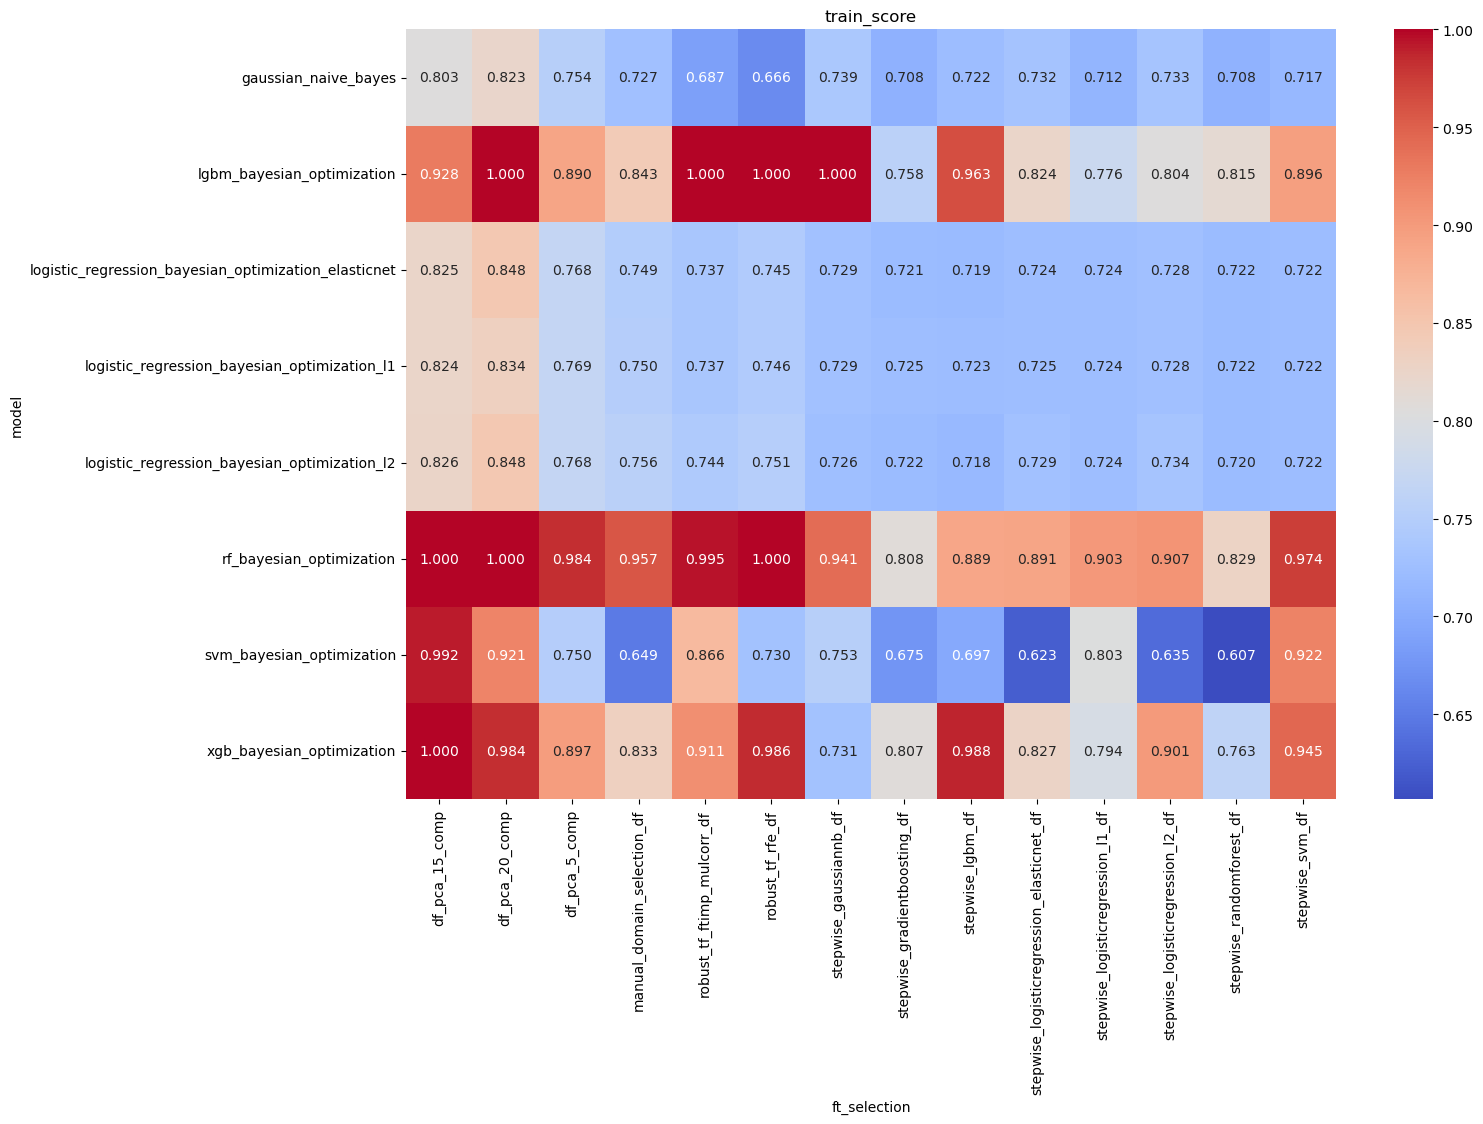

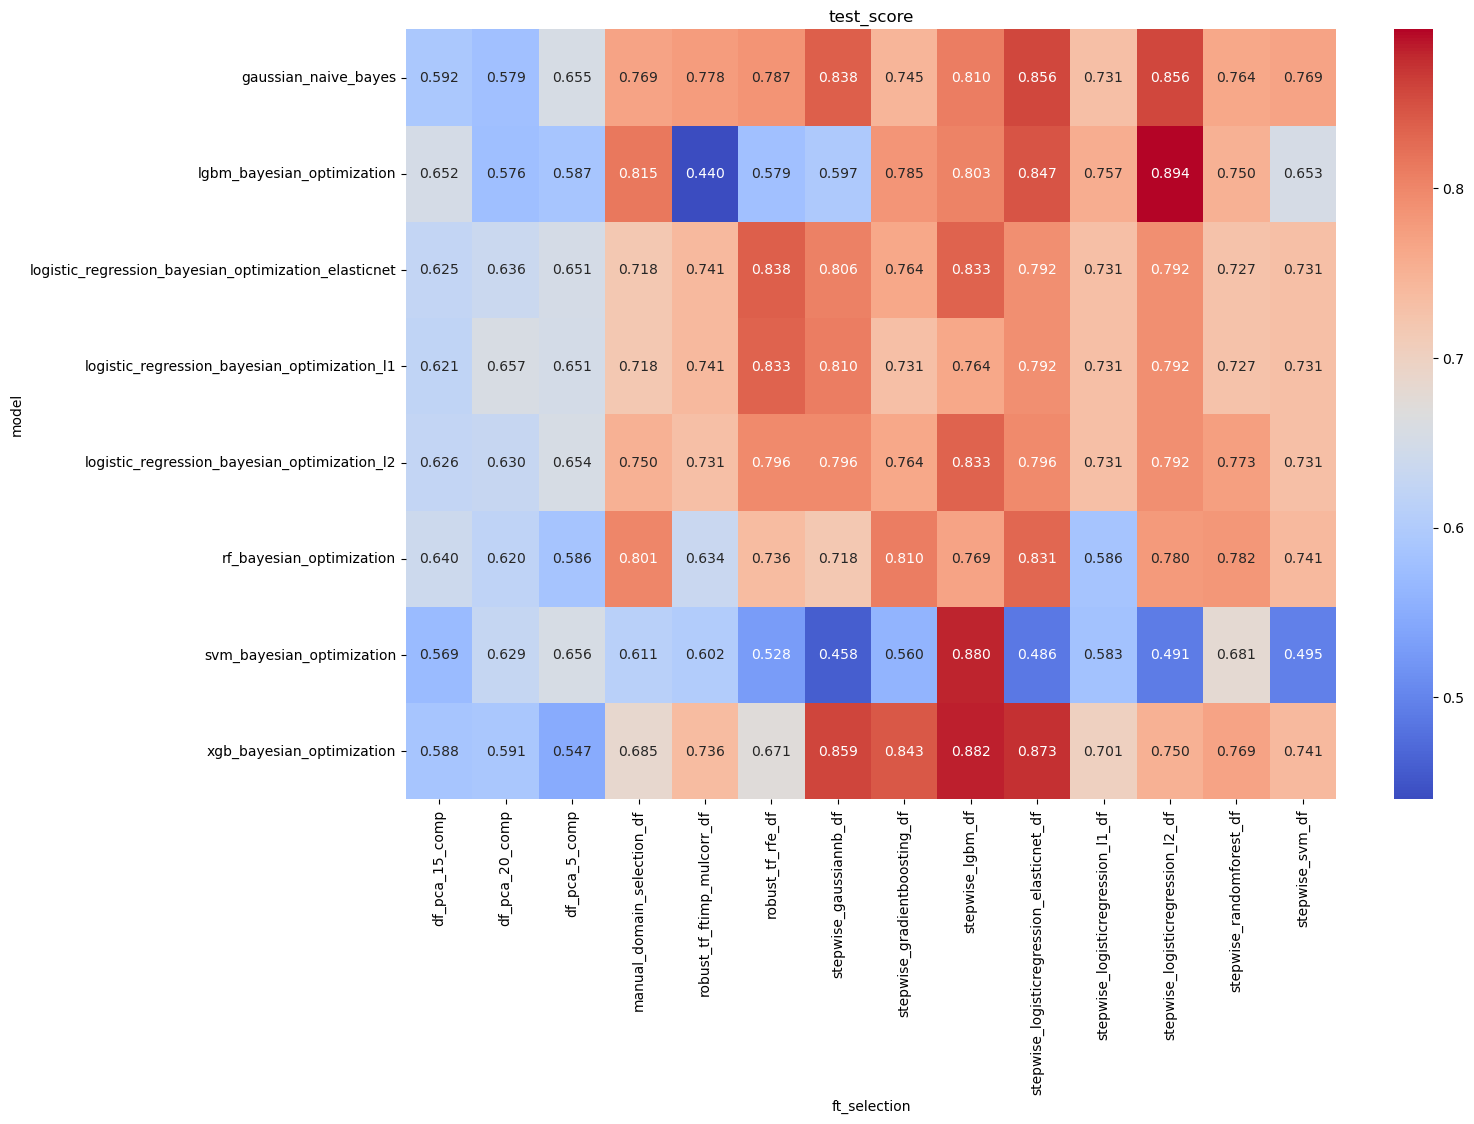

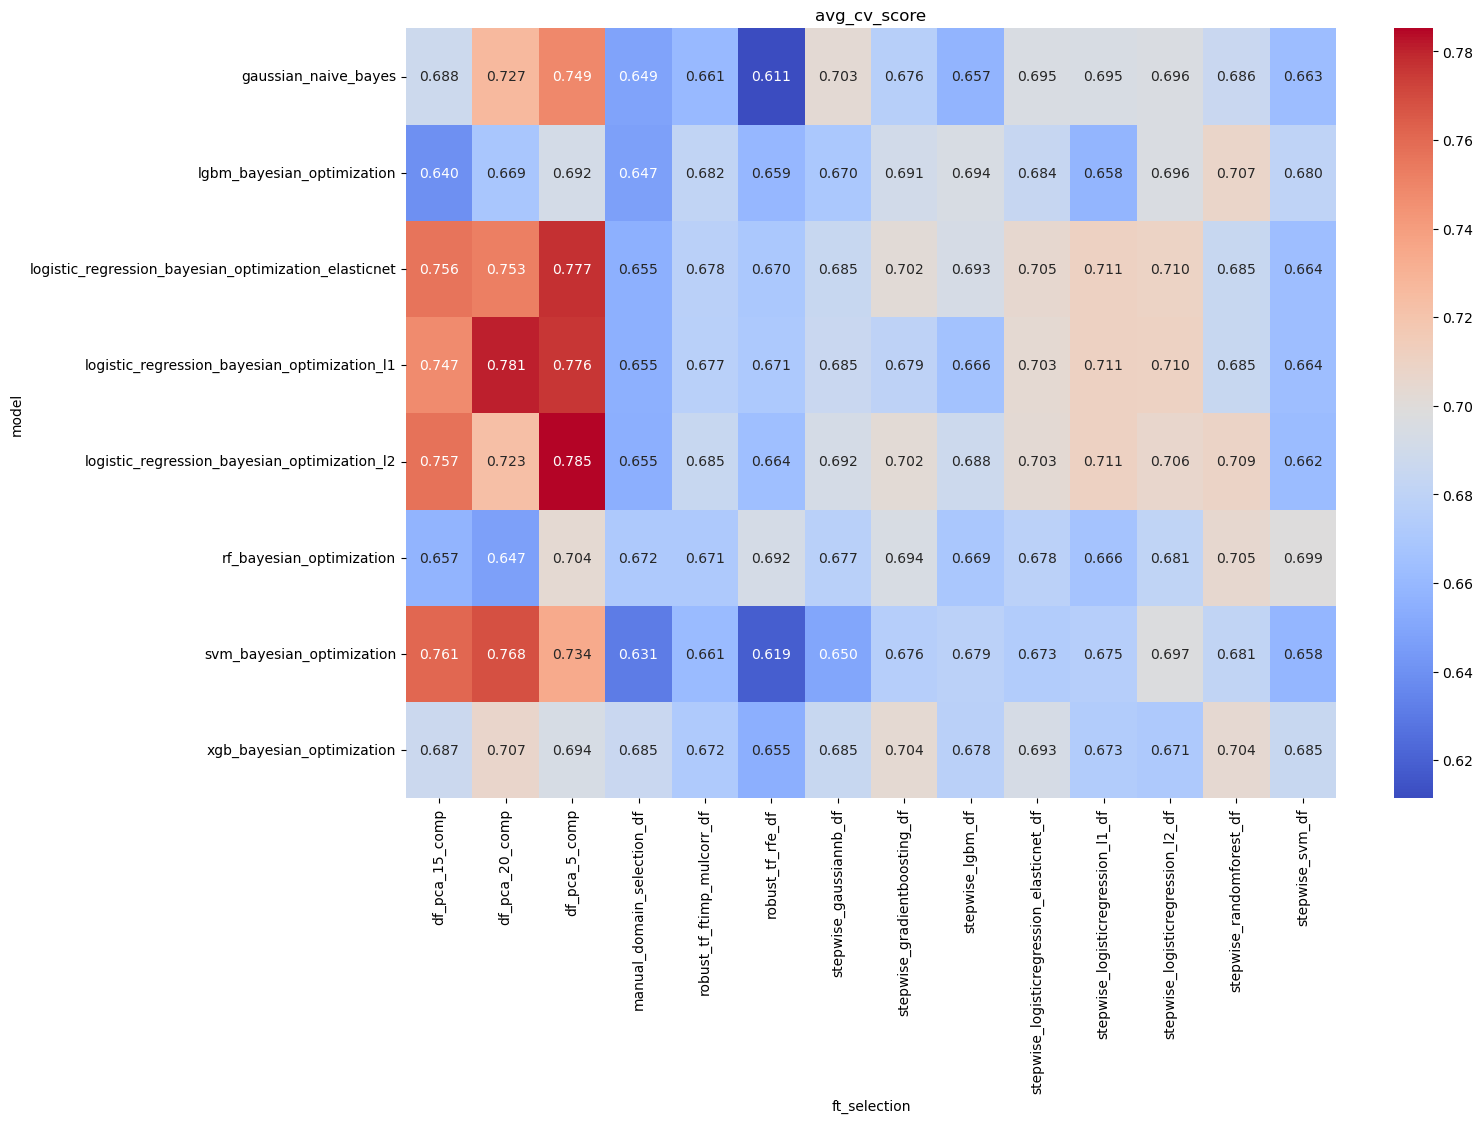

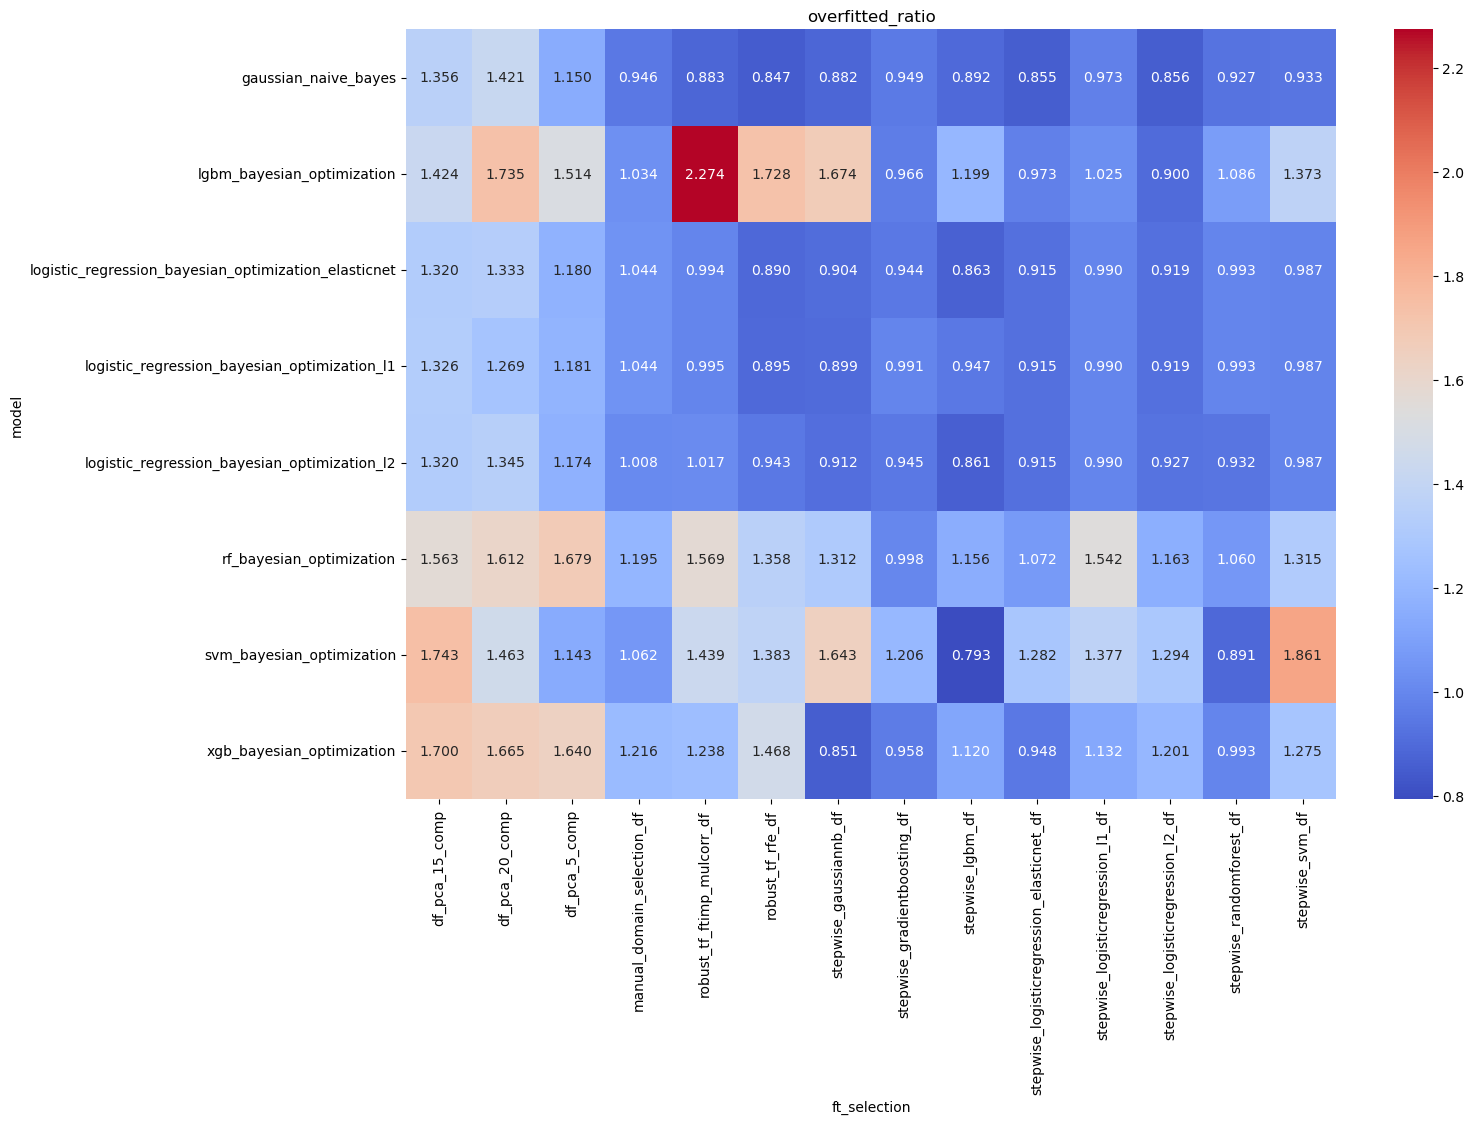

In [465]:
def eval_score_heatmap(score):
    heatmap_data = summarized_df.pivot(index="model", columns="ft_selection", values=score)
    plt.figure(figsize=(15, 10))
    sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="coolwarm")
    plt.title(score)
    plt.show()
eval_score_heatmap('train_score')
eval_score_heatmap('test_score')
eval_score_heatmap('avg_cv_score')
eval_score_heatmap('overfitted_ratio')

## Balance model

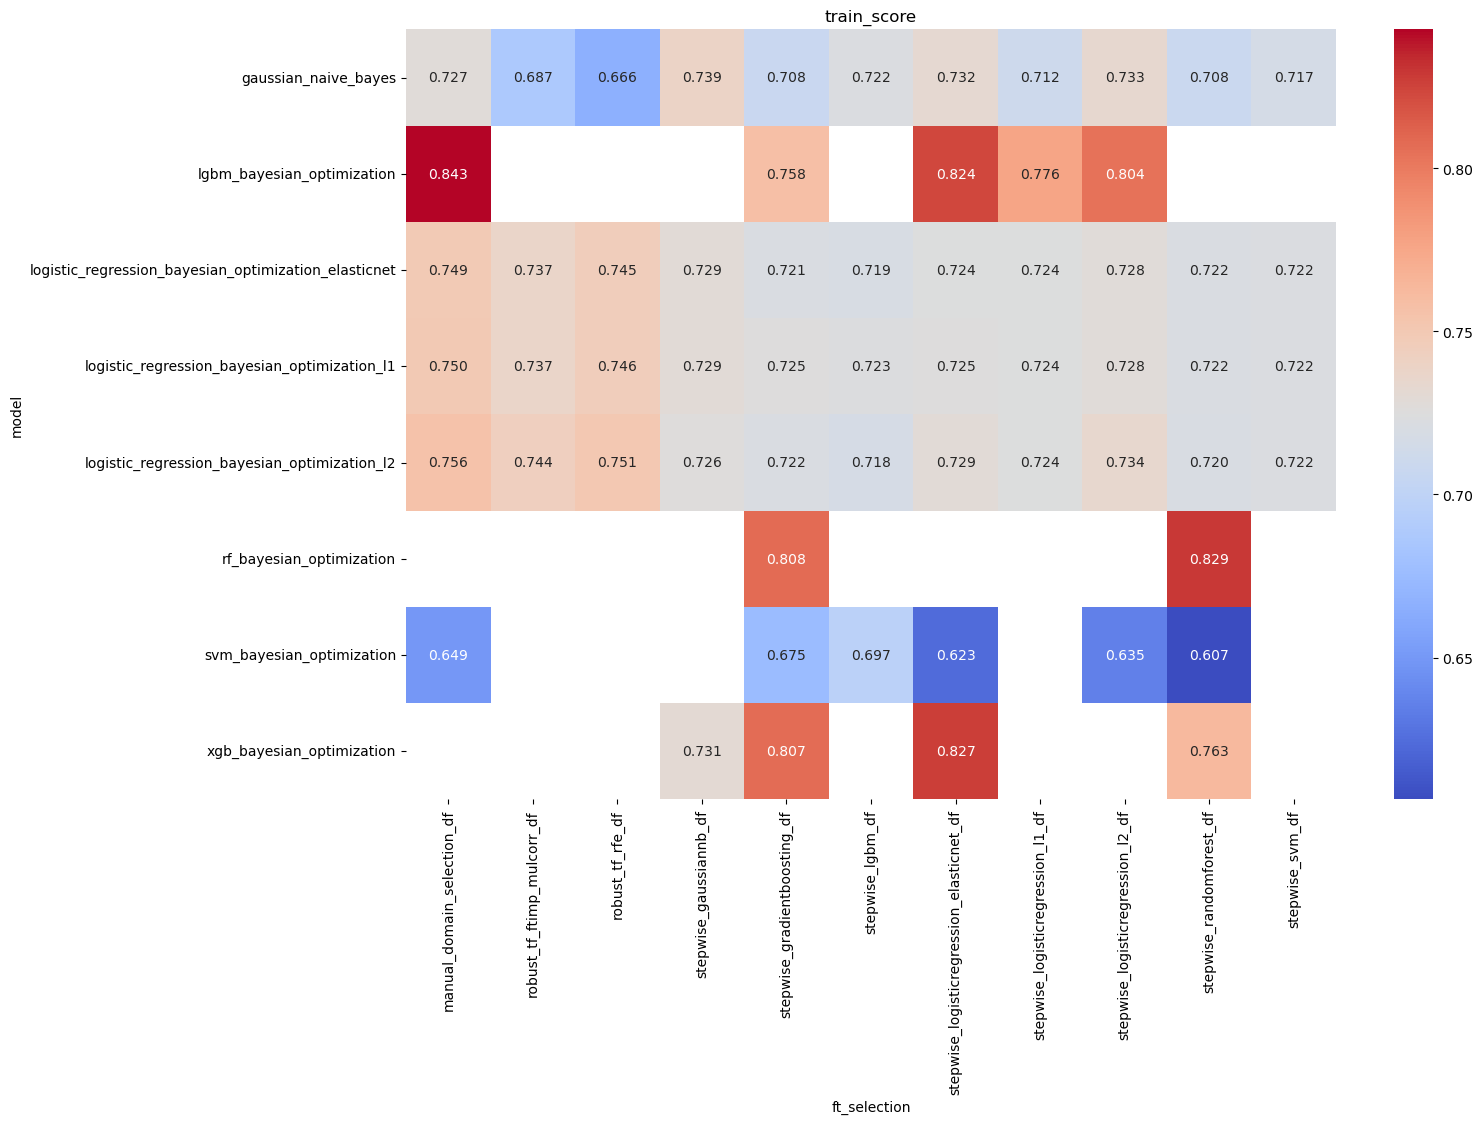

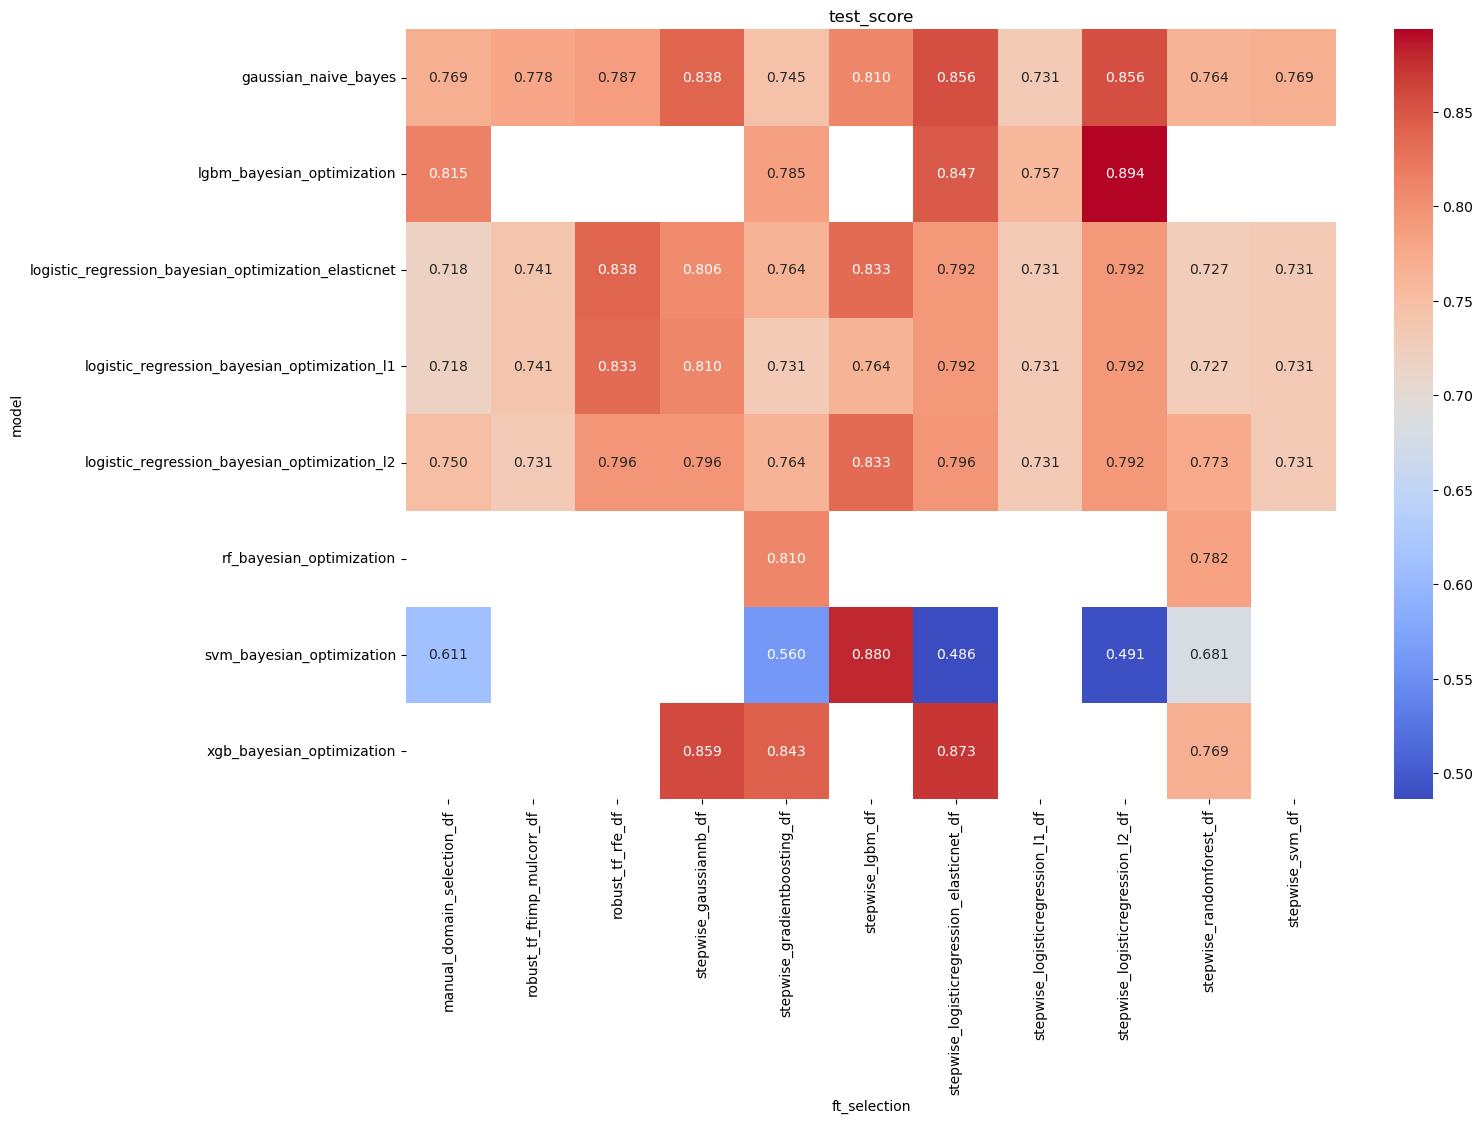

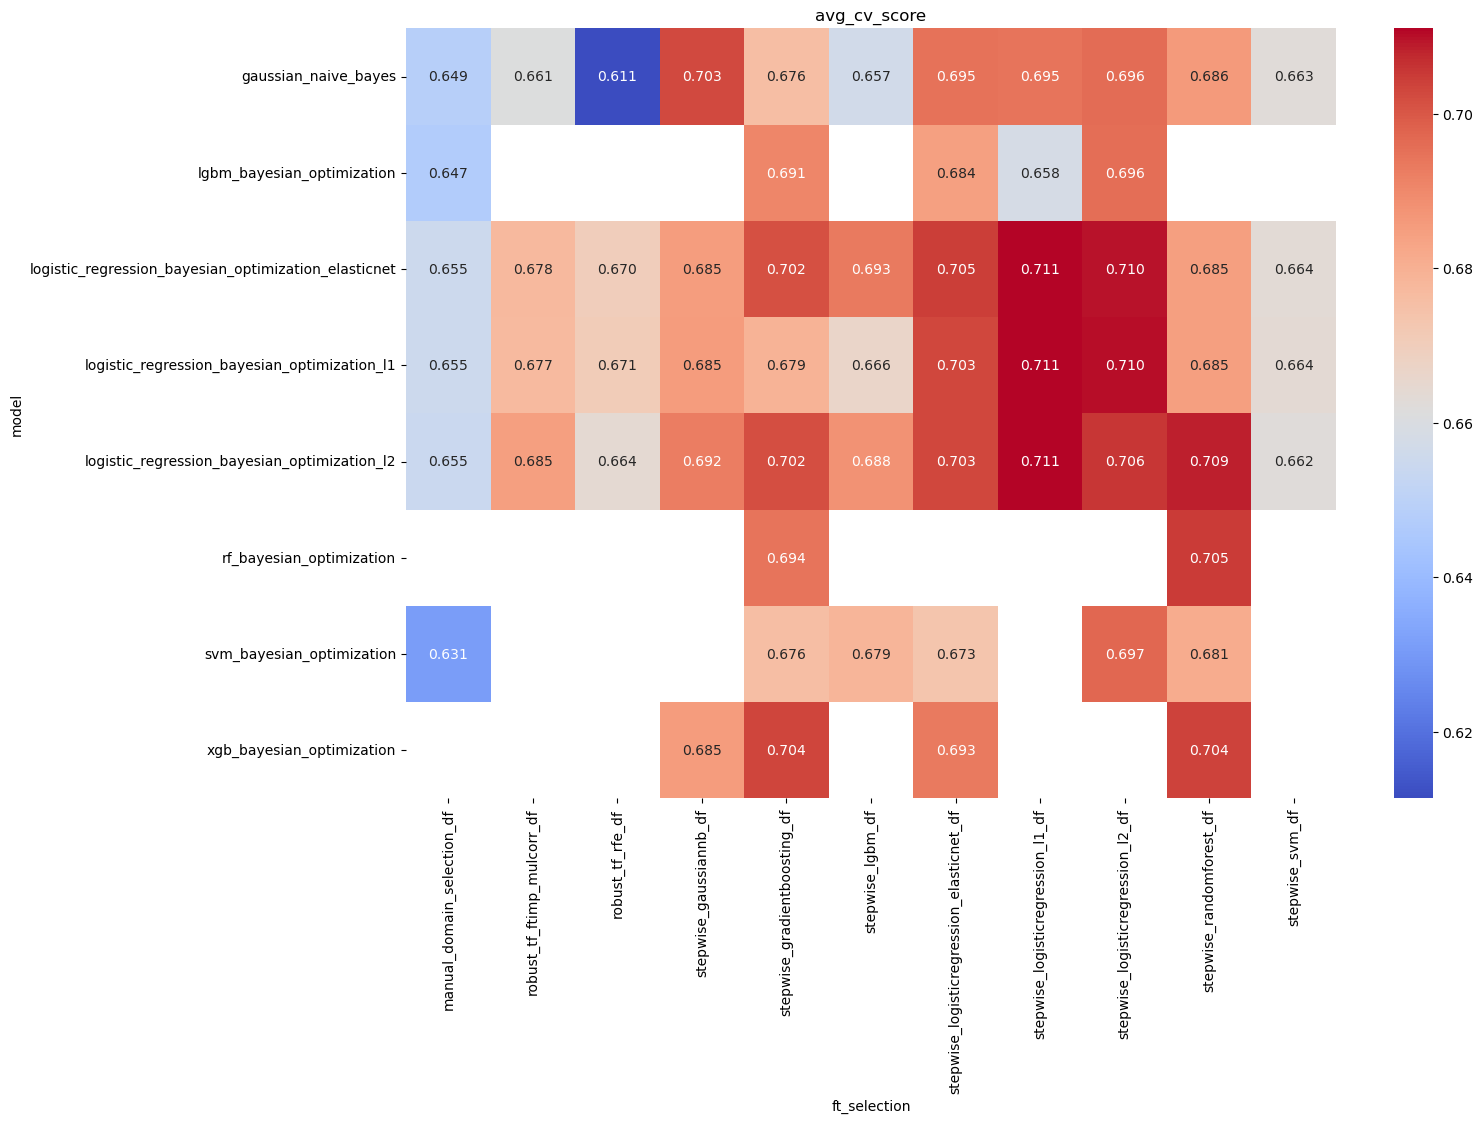

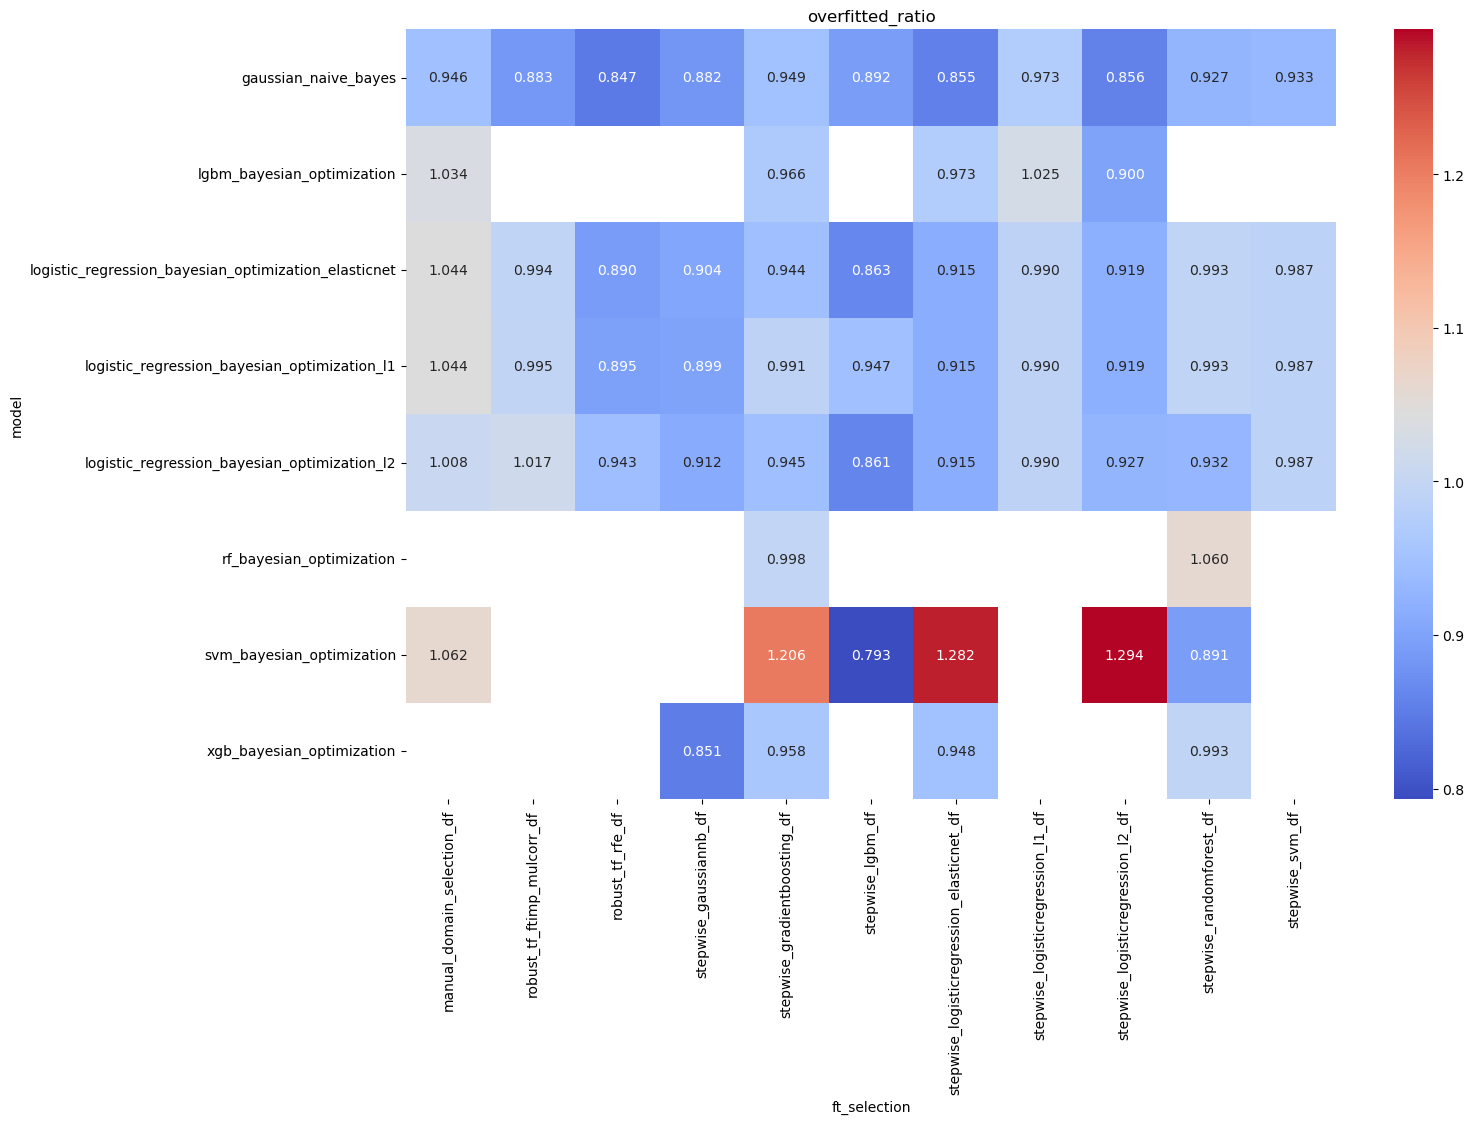

In [466]:
balanced_df = summarized_df.loc[summarized_df['estimate_status'] == "Balanced"]

def eval_score_heatmap(score):
    heatmap_data = balanced_df.pivot(index="model", columns="ft_selection", values=score)
    plt.figure(figsize=(15, 10))
    sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="coolwarm")
    plt.title(score)
    plt.show()
eval_score_heatmap('train_score')
eval_score_heatmap('test_score')
eval_score_heatmap('avg_cv_score')
eval_score_heatmap('overfitted_ratio')

# Final Model


In [467]:
# print("Test Date : ",set(df_test.index.date))

Model : gaussian_naive_bayes<br>
Feature Selection : df_pca_15_comp

In [468]:
# # Best Model --------------------------------------------------------------------
# best_model = gaussian_naive_bayes(df_pca_15_comp, 'y' ,'df_pca_15_comp')
# print(best_model)

# # PCA--------------------------------------------------------------------
# df = robust_tf_df.copy()
# y_column ='y'
# n_components=15

# X_train = df.drop(y_column, axis=1)
# y_train = df['y']
# # ทำ Scaling ข้อมูลฝึกฝน
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_train)
# pca = PCA(n_components=n_components)
# X_pca = pca.fit_transform(X_scaled)

# # ฝึกโมเดล Gaussian Naive Bayes
# best_model = GaussianNB()
# best_model.fit(X_pca, y_train)



# X_test = robust_tf_test_df.drop(y_column, axis=1)
# y_test = robust_tf_test_df['y']
# # ทำ Scaling และ PCA บนข้อมูลทดสอบ
# X_test_scaled = scaler.transform(X_test)
# X_test_pca = pca.transform(X_test_scaled)

# # ทำนายความน่าจะเป็นของคลาสบวกบนข้อมูลทดสอบ
# y_pred_proba = best_model.predict_proba(X_test_pca)[:, 1]

# # คำนวณ ROC AUC score
# roc_auc = roc_auc_score(y_test, y_pred_proba)
# print(f"ROC AUC Score on Test Set: {roc_auc}")
